In [ ]:
#%%

import os
os.makedirs('./credit_scoring/plots', exist_ok=True)
os.makedirs('./credit_scoring/models', exist_ok=True)

from ucimlrepo import fetch_ucirepo 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler, OneHotEncoder

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.manifold import TSNE

from imblearn.over_sampling import SMOTE

In [ ]:
#%%

# fetch dataset 
statlog_german_credit_data = fetch_ucirepo(id=144) 
  
# data (as pandas dataframes) 
X = statlog_german_credit_data.data.features 
y = statlog_german_credit_data.data.targets 
df = pd.concat([X, y], axis=1)

# metadata 
print(statlog_german_credit_data.metadata) 
  
# variable information 
print(statlog_german_credit_data.variables) 

{'uci_id': 144, 'name': 'Statlog (German Credit Data)', 'repository_url': 'https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data', 'data_url': 'https://archive.ics.uci.edu/static/public/144/data.csv', 'abstract': 'This dataset classifies people described by a set of attributes as good or bad credit risks. Comes in two formats (one all numeric). Also comes with a cost matrix', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1000, 'num_features': 20, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Other', 'Marital Status', 'Age', 'Occupation'], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5NC77', 'creators': ['Hans Hofmann'], 'intro_paper': None, 'additional_info': {'summary': 'Two datasets are provided.  the original dataset, in the form provided by

In [ ]:
#%%

from collections import Counter
Counter(y['class'])

Counter({1: 700, 2: 300})

In [ ]:
#%%

# 1. Dataset information
df.head()

Attribute1  Attribute2 Attribute3 Attribute4  Attribute5 Attribute6  \
0        A11           6        A34        A43        1169        A65   
1        A12          48        A32        A43        5951        A61   
2        A14          12        A34        A46        2096        A61   
3        A11          42        A32        A42        7882        A61   
4        A11          24        A33        A40        4870        A61   

  Attribute7  Attribute8 Attribute9 Attribute10  ...  Attribute12 Attribute13  \
0        A75           4        A93        A101  ...         A121          67   
1        A73           2        A92        A101  ...         A121          22   
2        A74           2        A93        A101  ...         A121          49   
3        A74           2        A93        A103  ...         A122          45   
4        A73           3        A93        A101  ...         A124          53   

   Attribute14 Attribute15 Attribute16  Attribute17 Attribute18  Attribute19  \
0         A143        A152           2         A173           1         A192   
1         A143        A152           1         A173           1         A191   
2         A143        A152           1         A172           2         A191   
3         A143        A153           1         A173           2         A191   
4         A143        A153           2         A173           2         A191   

  Attribute20 class  
0        A201     1  
1        A201     2  
2        A201     1  
3        A201     1  
4        A201     2  

[5 rows x 21 columns]

In [ ]:
#%%

print (f"Any NaN Value? {df.isna().any().any()}")
print (f"{df.shape=}")
df.info()

Any NaN Value? False
df.shape=(1000, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Attribute1   1000 non-null   object
 1   Attribute2   1000 non-null   int64 
 2   Attribute3   1000 non-null   object
 3   Attribute4   1000 non-null   object
 4   Attribute5   1000 non-null   int64 
 5   Attribute6   1000 non-null   object
 6   Attribute7   1000 non-null   object
 7   Attribute8   1000 non-null   int64 
 8   Attribute9   1000 non-null   object
 9   Attribute10  1000 non-null   object
 10  Attribute11  1000 non-null   int64 
 11  Attribute12  1000 non-null   object
 12  Attribute13  1000 non-null   int64 
 13  Attribute14  1000 non-null   object
 14  Attribute15  1000 non-null   object
 15  Attribute16  1000 non-null   int64 
 16  Attribute17  1000 non-null   object
 17  Attribute18  1000 non-null   int64 
 18  Attribute19  1000 non-null  

In [ ]:
#%%

# How many are continuous and how many are categorical?
continuous_features  = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

print(f"Number of continuous features: {len(continuous_features)}")
print(f"Number of categorical features: {len(categorical_features)}")

print("\nContinuous features:")
print(continuous_features)

print("\nCategorical features:")
print(categorical_features)

Number of continuous features: 7
Number of categorical features: 13

Continuous features:
Index(['Attribute2', 'Attribute5', 'Attribute8', 'Attribute11', 'Attribute13',
       'Attribute16', 'Attribute18'],
      dtype='object')

Categorical features:
Index(['Attribute1', 'Attribute3', 'Attribute4', 'Attribute6', 'Attribute7',
       'Attribute9', 'Attribute10', 'Attribute12', 'Attribute14',
       'Attribute15', 'Attribute17', 'Attribute19', 'Attribute20'],
      dtype='object')

Number of categorical features: 13

Continuous features:
Index(['Attribute2', 'Attribute5', 'Attribute8', 'Attribute11', 'Attribute13',
       'Attribute16', 'Attribute18'],
      dtype='object')

Categorical features:
Index(['Attribute1', 'Attribute3', 'Attribute4', 'Attribute6', 'Attribute7',
       'Attribute9', 'Attribute10', 'Attribute12', 'Attribute14',
       'Attribute15', 'Attribute17', 'Attribute19', 'Attribute20'],
      dtype='object')


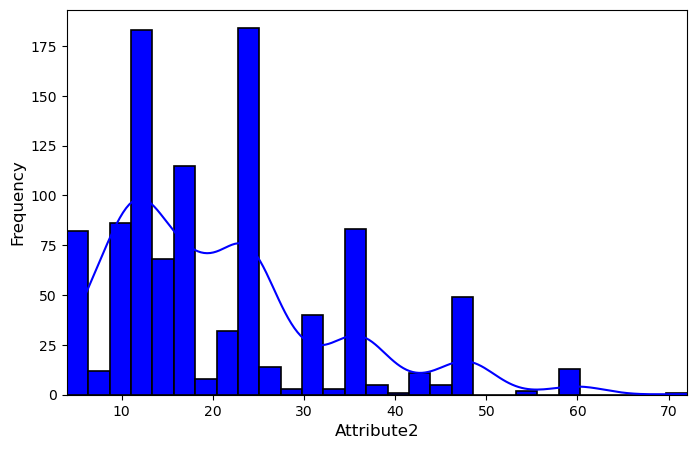

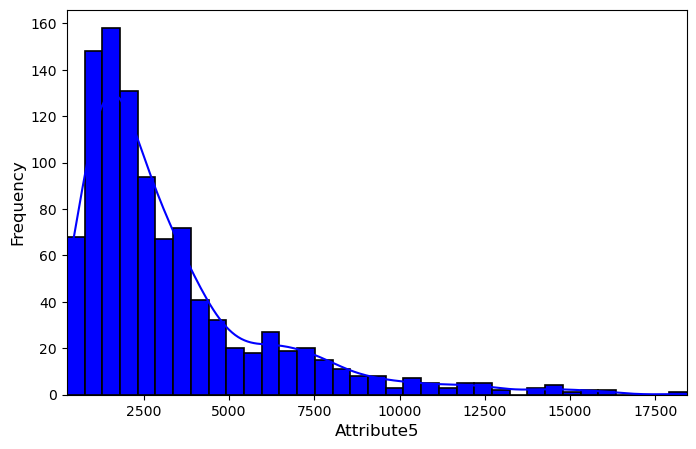

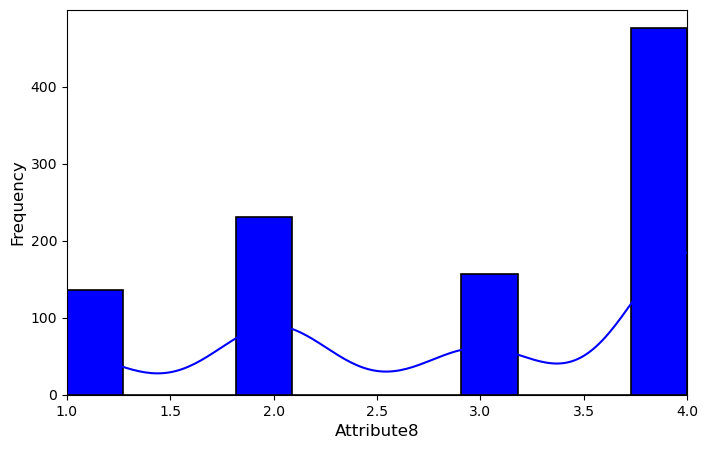

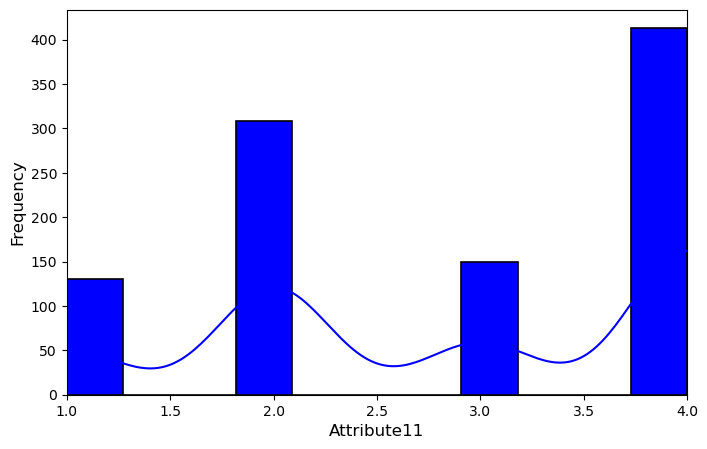

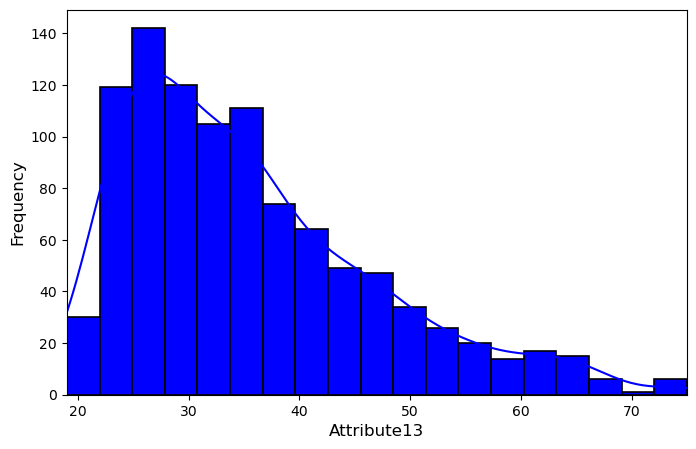

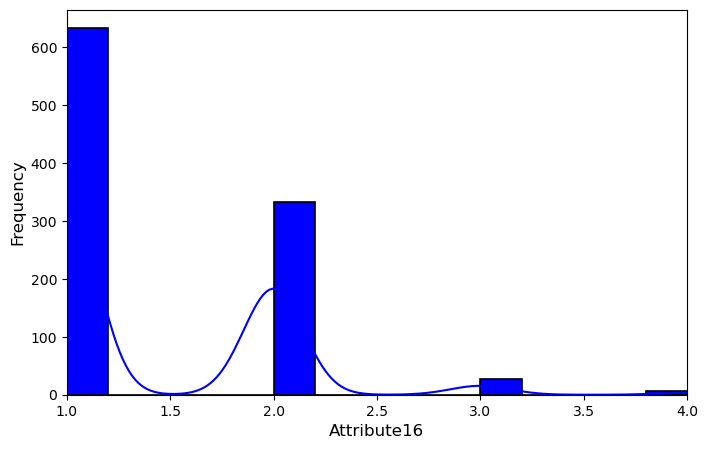

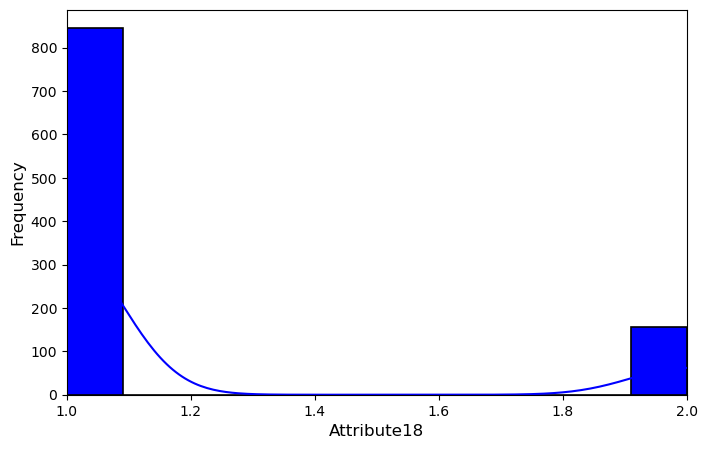

In [ ]:
# %%

# Inspecting continous data distribution
std = {}
for feature in (continuous_features):
    plt.figure(figsize=(8, 5)) 
    sns.histplot(x=X[feature], color='b', kde=True, linewidth=1.2, alpha=1)
    
    plt.xlabel(feature.replace('-', ' ').capitalize(), fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xlim([min(X[feature].values), max(X[feature].values)])
    
    filename = "dist_" + feature + ".png"
    file_path = os.path.join('./credit_scoring/plots', filename)
    if not os.path.exists(file_path):
        plt.savefig(file_path)
    plt.show()

    std[feature] = X[feature].std()

In [ ]:
#%%

# Standard deviation
print ("Standard deviation of features:")
for key, value in zip(std.keys(), std.values()):
    print (f"{key}={value:.2f}")

Standard deviation of features:
Attribute2=12.06
Attribute5=2822.74
Attribute8=1.12
Attribute11=1.10
Attribute13=11.38
Attribute16=0.58
Attribute18=0.36


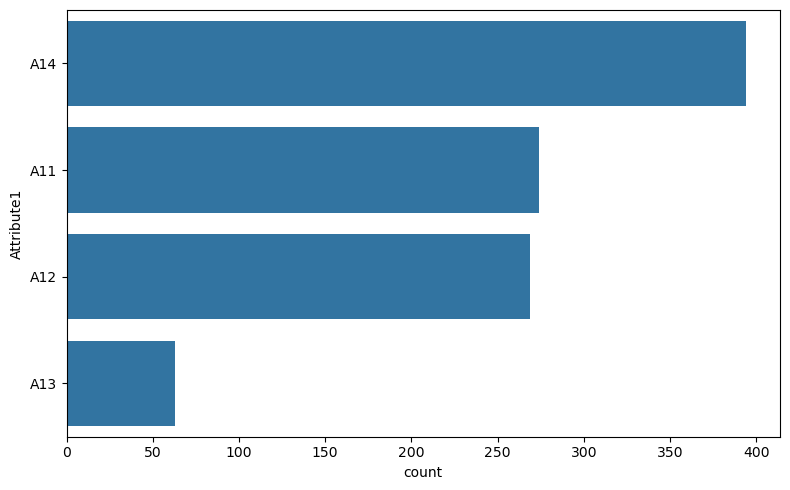

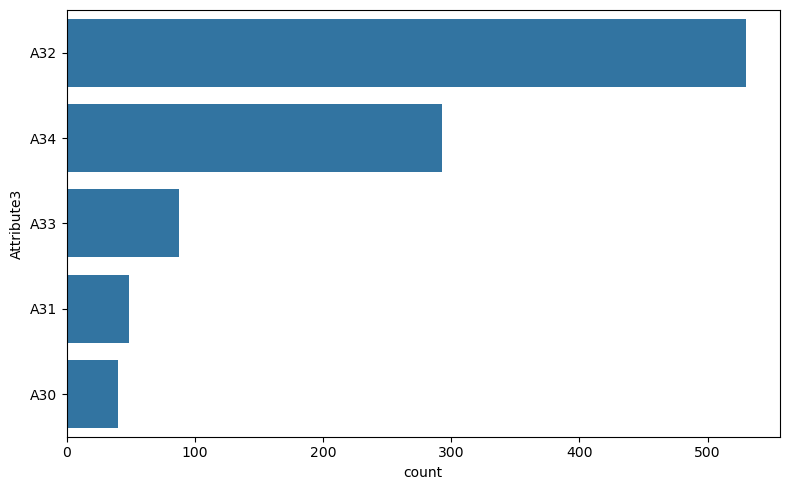

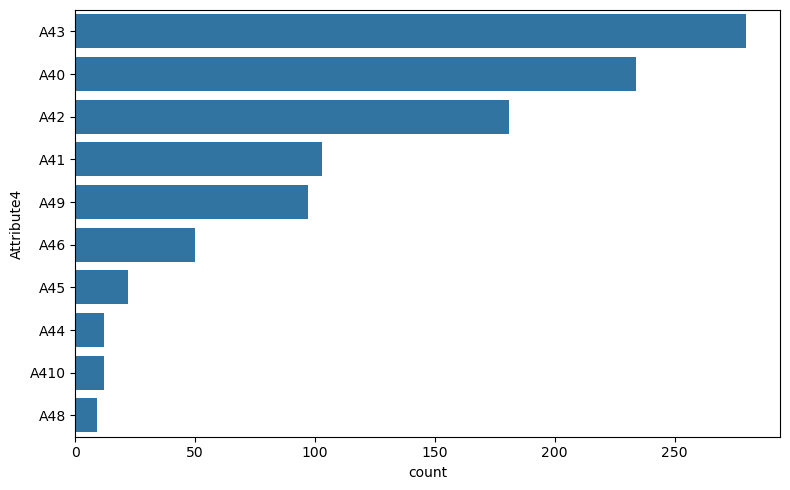

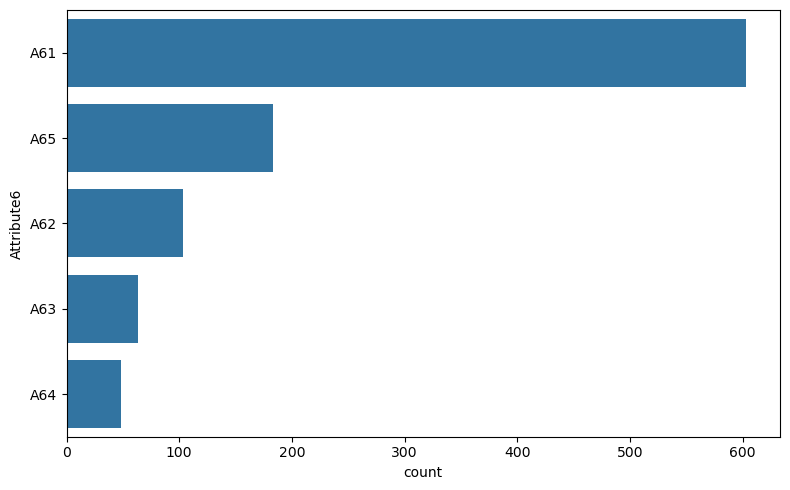

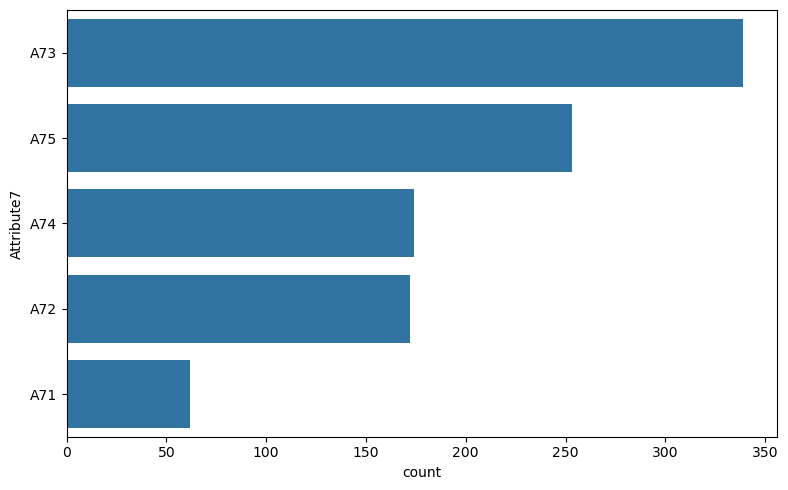

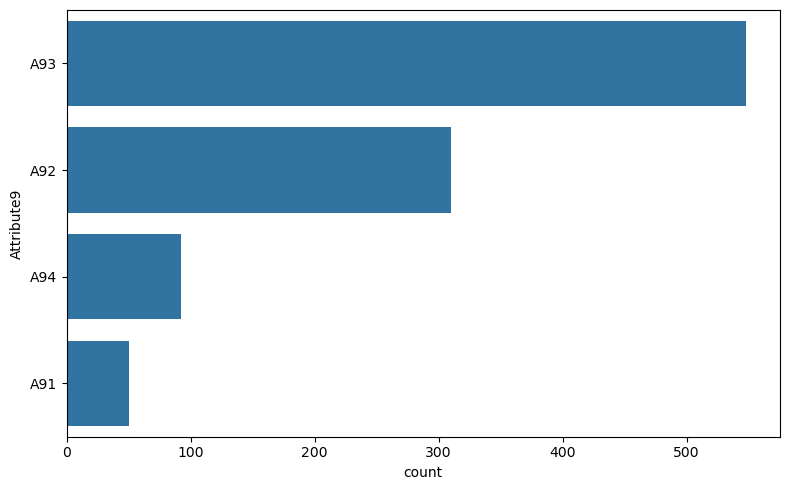

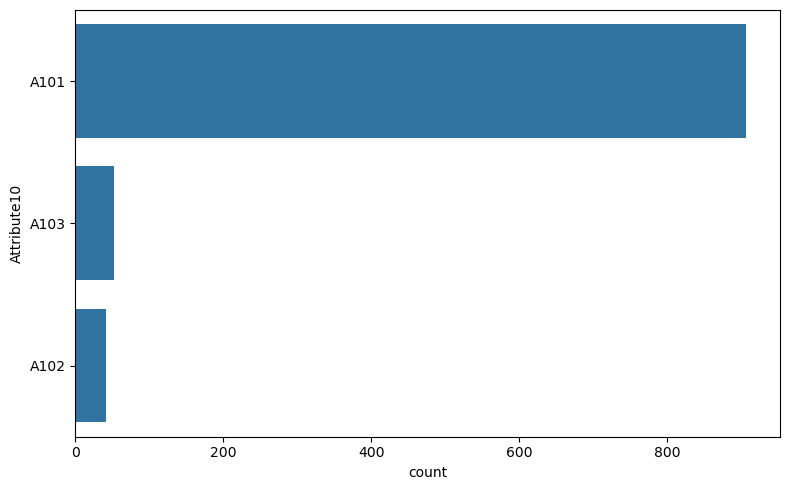

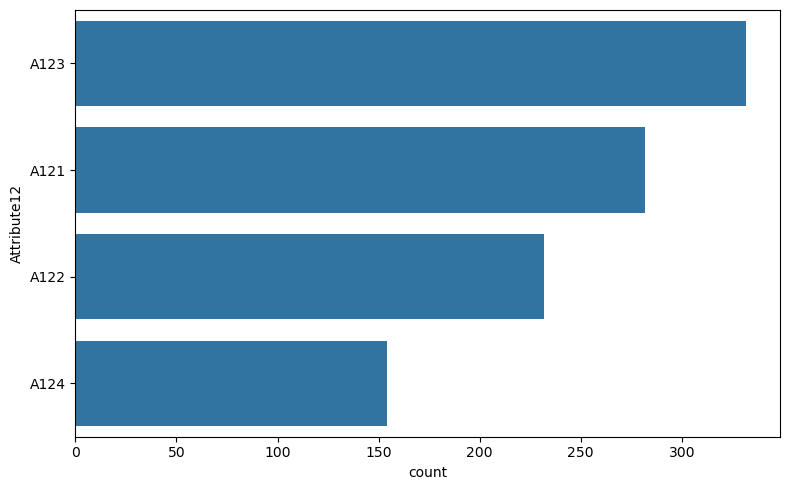

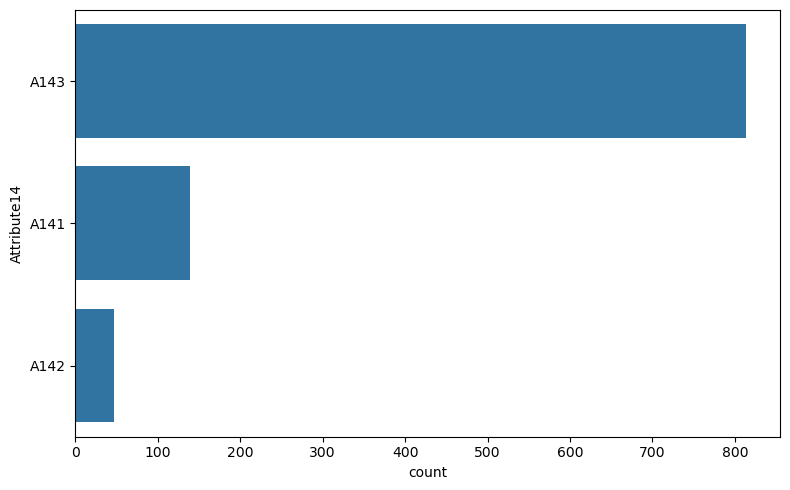

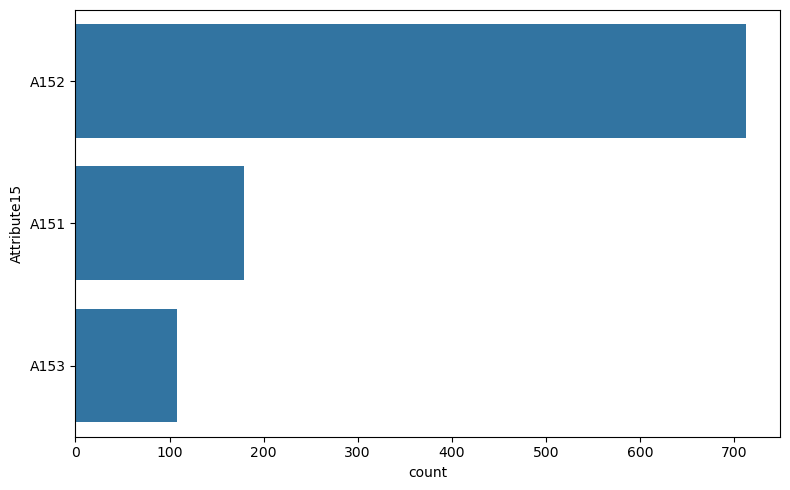

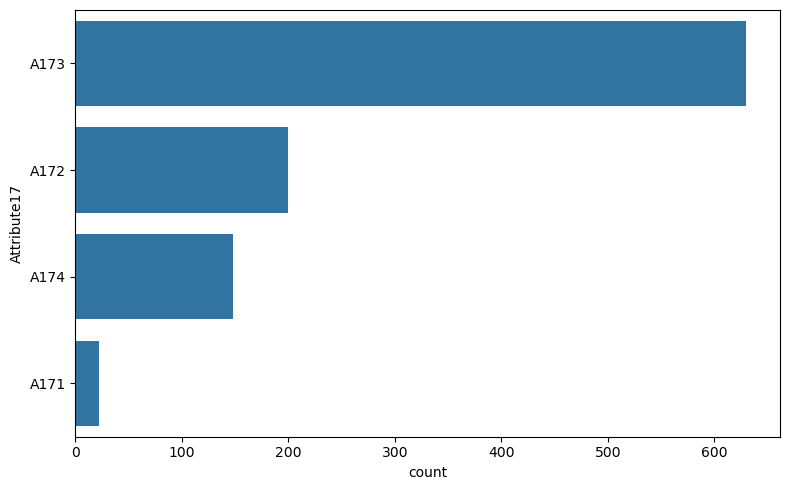

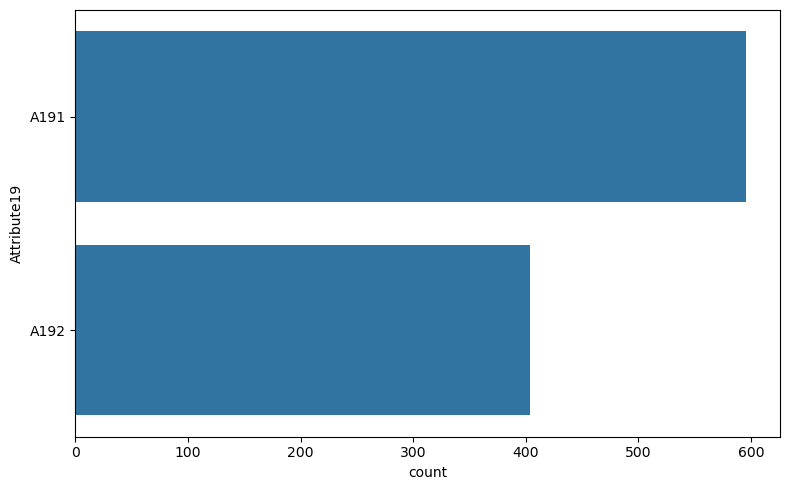

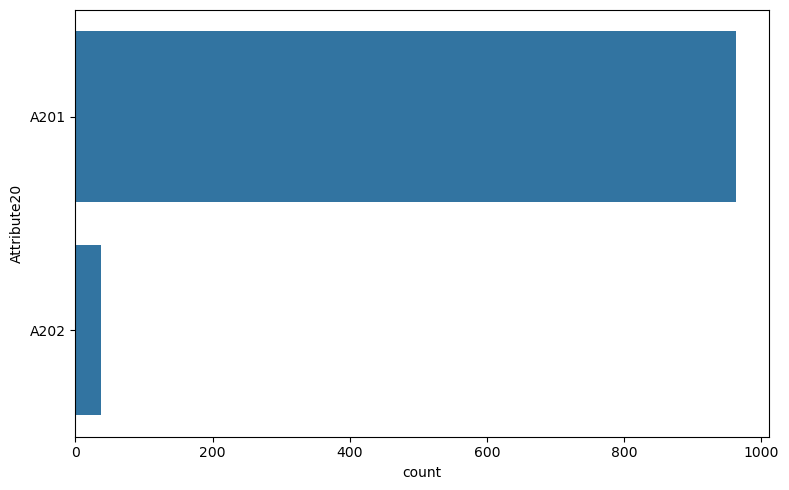

In [ ]:
#%%

# Inspecting categorical data distribution
for feature in (categorical_features):
    plt.figure(figsize=(8, 5))
    sns.countplot(y=feature, data=df, order=df[feature].value_counts().index)
    plt.tight_layout()

    filename = "cplot_" + feature + ".png"
    file_path = os.path.join('./credit_scoring/plots', filename)
    if not os.path.exists(file_path):
        plt.savefig(file_path)
    plt.show()

In [ ]:
#%%

# Handling multivariate features
X.loc[:, continuous_features] = RobustScaler().fit_transform(X[continuous_features])

encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' para evitar la multicolinealidad (one feature is a linear combination of others)
encoded_categorical = encoder.fit_transform(X[categorical_features])

encoded_X = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_features))

X = X.drop(columns=categorical_features).reset_index(drop=True)
encoded_X = encoded_X.reset_index(drop=True)
X = pd.concat([X, encoded_X], axis=1)

<ipython-input-10-73614b90a364>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.          2.5        -0.5         2.          0.5         1.5
  0.5         1.5        -0.5         1.         -0.5         2.5
 -0.5         0.5        -0.25        0.5         0.5         1.
  0.5         0.5        -0.75       -1.         -0.66666667 -0.5
 -0.66666667 -1.         -1.         -0.5        -0.91666667  3.5
  0.          0.5         0.         -0.5        -0.5         2.25
  2.5         0.         -0.66666667 -0.75        1.         -0.5
  0.          1.          2.5        -0.58333333  1.5        -1.
 -0.58333333 -0.5         0.5         0.75       -0.5         0.
  1.5        -1.         -0.5         1.5         0.          1.5
 -0.75       -0.25        1.5         2.5         0.5         0.75
 -0.5        -0.5         1.5         1.5         1.5        -0.91666667
 -0.83333333  2.          1.5        -0.5        

In [ ]:
X

Attribute2  Attribute5  Attribute8  Attribute11  Attribute13  \
0         -1.00   -0.441354         0.5          0.5     2.266667   
1          2.50    1.393114        -0.5         -0.5    -0.733333   
2         -0.50   -0.085739        -0.5          0.0     1.066667   
3          2.00    2.133883        -0.5          0.5     0.800000   
4          0.50    0.978421         0.0          0.5     1.333333   
..          ...         ...         ...          ...          ...   
995       -0.50   -0.223842         0.0          0.5    -0.133333   
996        1.00    0.589815         0.5          0.5     0.466667   
997       -0.50   -0.581375         0.5          0.5     0.333333   
998        2.25   -0.182027         0.5          0.5    -0.666667   
999        2.25    0.865637         0.0          0.5    -0.400000   

     Attribute16  Attribute18  Attribute1_A12  Attribute1_A13  Attribute1_A14  \
0              1            0             0.0             0.0             0.0   
1              0            0             1.0             0.0             0.0   
2              0            1             0.0             0.0             1.0   
3              0            1             0.0             0.0             0.0   
4              1            1             0.0             0.0             0.0   
..           ...          ...             ...             ...             ...   
995            0            0             0.0             0.0             1.0   
996            0            0             0.0             0.0             0.0   
997            0            0             0.0             0.0             1.0   
998            0            0             0.0             0.0             0.0   
999            0            0             1.0             0.0             0.0   

     ...  Attribute12_A124  Attribute14_A142  Attribute14_A143  \
0    ...               0.0               0.0               1.0   
1    ...               0.0               0.0               1.0   
2    ...               0.0               0.0               1.0   
3    ...               0.0               0.0               1.0   
4    ...               1.0               0.0               1.0   
..   ...               ...               ...               ...   
995  ...               0.0               0.0               1.0   
996  ...               0.0               0.0               1.0   
997  ...               0.0               0.0               1.0   
998  ...               1.0               0.0               1.0   
999  ...               0.0               0.0               1.0   

     Attribute15_A152  Attribute15_A153  Attribute17_A172  Attribute17_A173  \
0                 1.0               0.0               0.0               1.0   
1                 1.0               0.0               0.0               1.0   
2                 1.0               0.0               1.0               0.0   
3                 0.0               1.0               0.0               1.0   
4                 0.0               1.0               0.0               1.0   
..                ...               ...               ...               ...   
995               1.0               0.0               1.0               0.0   
996               1.0               0.0               0.0               0.0   
997               1.0               0.0               0.0               1.0   
998               0.0               1.0               0.0               1.0   
999               1.0               0.0               0.0               1.0   

     Attribute17_A174  Attribute19_A192  Attribute20_A202  
0                 0.0               1.0               0.0  
1                 0.0               0.0               0.0  
2                 0.0               0.0               0.0  
3                 0.0               0.0               0.0  
4                 0.0               0.0               0.0  
..                ...               ...               ...  
995               0.0               0.0  

In [ ]:
X.shape

(1000, 48)

<ipython-input-13-5a4d7eb3ab7e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  tg_dist = sns.countplot(data=df, x='class', palette='cividis')
<ipython-input-13-5a4d7eb3ab7e>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  tg_dist.set_xticklabels(['Good', 'Bad'])


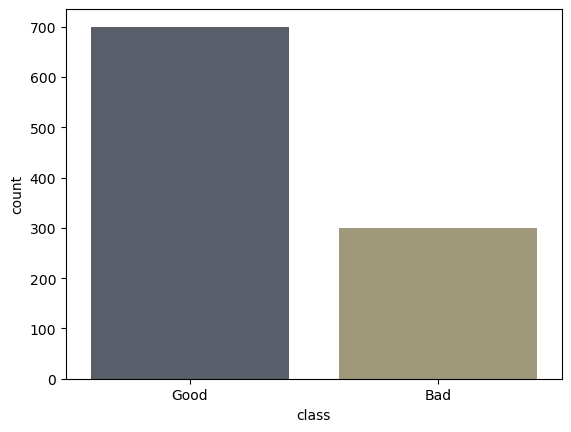

In [ ]:
#%%

# Target distibution
tg_dist = sns.countplot(data=df, x='class', palette='cividis')
tg_dist.set_xticklabels(['Good', 'Bad'])
if not os.path.exists('./credit_scoring/plots/y_dist_imbal'):
    plt.savefig('./credit_scoring/plots/y_dist_imbal')
plt.show()

# Since we have an imbalanced dataset with few samples -> Oversampling

In [ ]:
#%%

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=37, stratify=y)

In [ ]:
#%%

# Oversampling
X_oversampled, y_oversampled = SMOTE(random_state=37).fit_resample(X_train, y_train)

In [ ]:
#%%

# Oversampling
X_oversampled, y_oversampled = SMOTE(random_state=37).fit_resample(X_train, y_train)
data_oversampled = pd.concat([X_oversampled,y_oversampled], axis=1)

In [ ]:
#%%

# Oversampling
X_oversampled, y_oversampled = SMOTE(random_state=37).fit_resample(X_train, y_train)
df_oversampled = pd.concat([X_oversampled,y_oversampled], axis=1)

<ipython-input-18-dd43c363d4f1>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  tg_dist_2 = sns.countplot(data=df_oversampled, x='class', palette='cividis')
<ipython-input-18-dd43c363d4f1>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  tg_dist_2.set_xticklabels(['Good','Bad'])


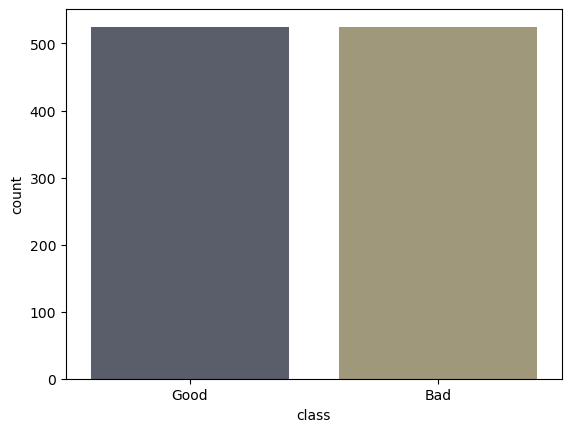

In [ ]:
#%%

# Correlation matrix
tg_dist_2 = sns.countplot(data=df_oversampled, x='class', palette='cividis')
tg_dist_2.set_xticklabels(['Good','Bad'])
if not os.path.exists('./credit_scoring/plots/y_dist_bal'):
    plt.savefig('./credit_scoring/plots/y_dist_bal')
plt.show()

<ipython-input-19-1653a5d5c8a6>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  tg_dist_2 = sns.countplot(data=df_oversampled, x='class', palette='cividis', legend=False)
<ipython-input-19-1653a5d5c8a6>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  tg_dist_2.set_xticklabels(['Good','Bad'])


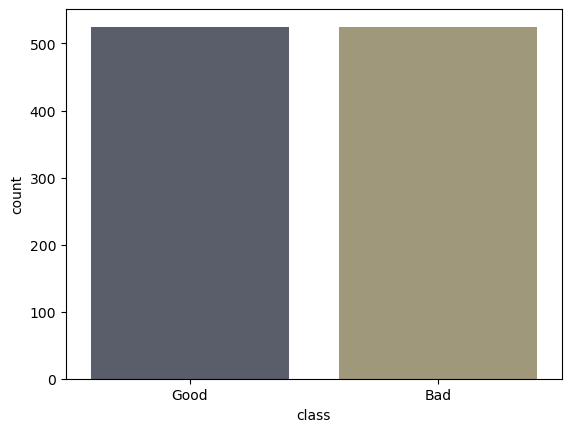

In [ ]:
#%%

# Correlation matrix
tg_dist_2 = sns.countplot(data=df_oversampled, x='class', palette='cividis', legend=False)
tg_dist_2.set_xticklabels(['Good','Bad'])
if not os.path.exists('./credit_scoring/plots/y_dist_bal'):
    plt.savefig('./credit_scoring/plots/y_dist_bal')
plt.show()

<ipython-input-20-1d25fcd2bfa1>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  tg_dist_2.set_xticklabels(['Good','Bad'])


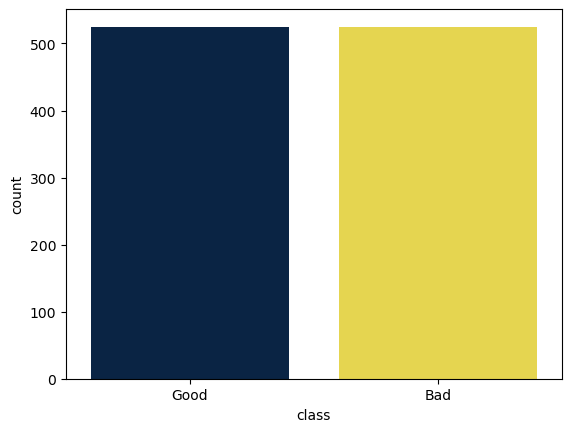

In [ ]:
#%%

# Correlation matrix
tg_dist_2 = sns.countplot(data=df_oversampled, x='class', hue='class', palette='cividis', legend=False)
tg_dist_2.set_xticklabels(['Good','Bad'])
if not os.path.exists('./credit_scoring/plots/y_dist_bal'):
    plt.savefig('./credit_scoring/plots/y_dist_bal')
plt.show()

<ipython-input-21-74c18cc33e21>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  tg_dist_2.set_xticklabels(['Good','Bad'])


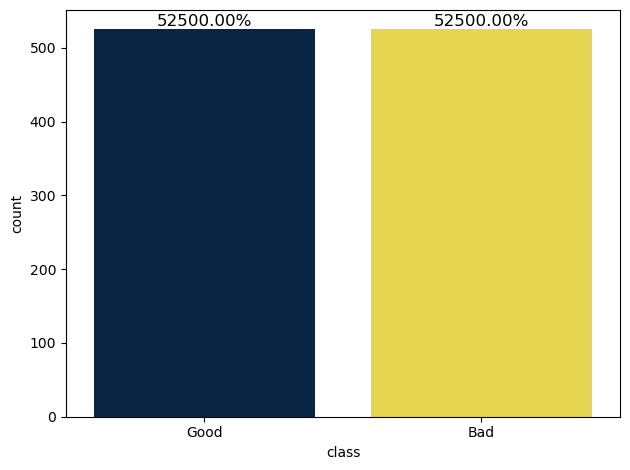

In [ ]:
#%%

# Correlation matrix
tg_dist_2 = sns.countplot(data=df_oversampled, x='class', hue='class', palette='cividis', legend=False)
tg_dist_2.set_xticklabels(['Good','Bad'])

for p in tg_dist_2.patches:
    tg_dist_2.annotate(f'{p.get_height():.2%}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom', fontsize=12)
    
plt.tight_layout()

if not os.path.exists('./credit_scoring/plots/y_dist_bal'):
    plt.savefig('./credit_scoring/plots/y_dist_bal')
plt.show()

In [ ]:
p.get_height

<bound method Rectangle.get_height of <matplotlib.patches.Rectangle object at 0x0000023883E46360>>

In [ ]:
p.get_height()

525.0

<ipython-input-24-e8acc71c85fd>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  tg_dist_2.set_xticklabels(['Good','Bad'])


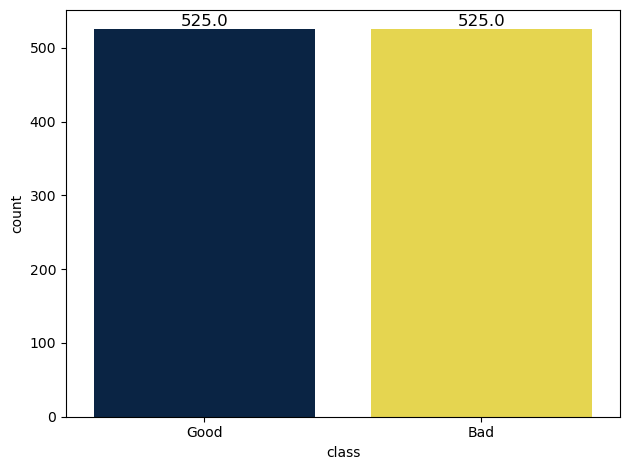

In [ ]:
#%%

# Correlation matrix
tg_dist_2 = sns.countplot(data=df_oversampled, x='class', hue='class', palette='cividis', legend=False)
tg_dist_2.set_xticklabels(['Good','Bad'])

for p in tg_dist_2.patches:
    tg_dist_2.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom', fontsize=12)
    
plt.tight_layout()

if not os.path.exists('./credit_scoring/plots/y_dist_bal'):
    plt.savefig('./credit_scoring/plots/y_dist_bal')
plt.show()

<ipython-input-25-e02821bd815e>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  tg_dist_2.set_xticklabels(['Good','Bad'])


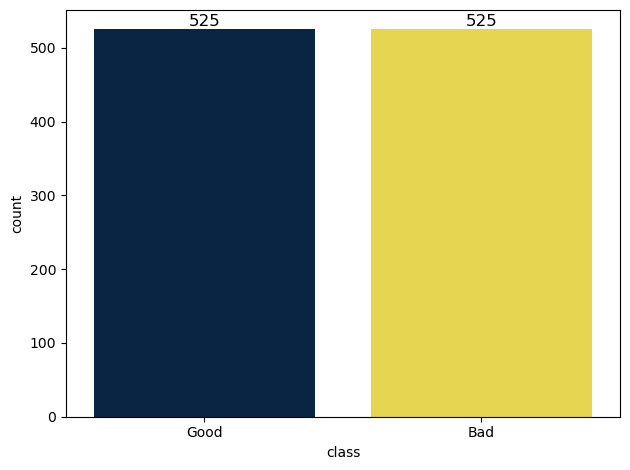

In [ ]:
#%%

# Correlation matrix
tg_dist_2 = sns.countplot(data=df_oversampled, x='class', hue='class', palette='cividis', legend=False)
tg_dist_2.set_xticklabels(['Good','Bad'])

for p in tg_dist_2.patches:
    tg_dist_2.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom', fontsize=12)
    
plt.tight_layout()

if not os.path.exists('./credit_scoring/plots/y_dist_bal'):
    plt.savefig('./credit_scoring/plots/y_dist_bal')
plt.show()

<ipython-input-26-2befb51e0b3c>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  tg_dist.set_xticklabels(['Good', 'Bad'])


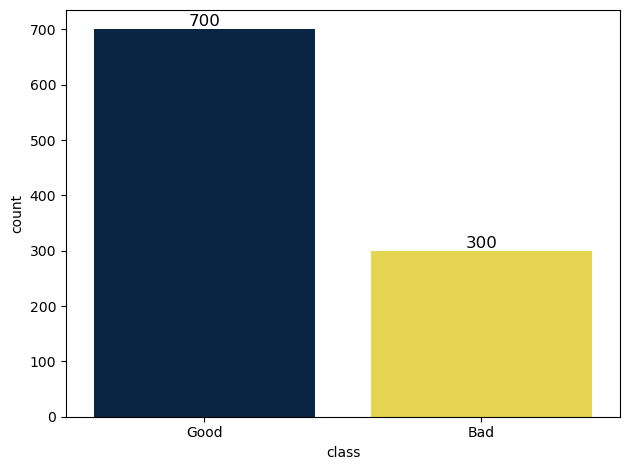

In [ ]:
#%%

# Target distibution
tg_dist = sns.countplot(data=df, x='class', hue='class', palette='cividis', legend=False)
tg_dist.set_xticklabels(['Good', 'Bad'])

for p in tg_dist.patches:
    tg_dist.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom', fontsize=12)
    
plt.tight_layout()

if not os.path.exists('./credit_scoring/plots/y_dist_imbal'):
    plt.savefig('./credit_scoring/plots/y_dist_imbal')
plt.show()

# Since we have an imbalanced dataset with few samples -> Oversampling

In [ ]:
#%%

import os
os.makedirs('./credit_scoring/plots', exist_ok=True)
os.makedirs('./credit_scoring/models', exist_ok=True)

from ucimlrepo import fetch_ucirepo 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler, OneHotEncoder

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.manifold import TSNE

from imblearn.over_sampling import SMOTE

from collections import Counter

In [ ]:
Counter(y)

Counter({'class': 1})

In [ ]:
X

Attribute2  Attribute5  Attribute8  Attribute11  Attribute13  \
0         -1.00   -0.441354         0.5          0.5     2.266667   
1          2.50    1.393114        -0.5         -0.5    -0.733333   
2         -0.50   -0.085739        -0.5          0.0     1.066667   
3          2.00    2.133883        -0.5          0.5     0.800000   
4          0.50    0.978421         0.0          0.5     1.333333   
..          ...         ...         ...          ...          ...   
995       -0.50   -0.223842         0.0          0.5    -0.133333   
996        1.00    0.589815         0.5          0.5     0.466667   
997       -0.50   -0.581375         0.5          0.5     0.333333   
998        2.25   -0.182027         0.5          0.5    -0.666667   
999        2.25    0.865637         0.0          0.5    -0.400000   

     Attribute16  Attribute18  Attribute1_A12  Attribute1_A13  Attribute1_A14  \
0              1            0             0.0             0.0             0.0   
1              0            0             1.0             0.0             0.0   
2              0            1             0.0             0.0             1.0   
3              0            1             0.0             0.0             0.0   
4              1            1             0.0             0.0             0.0   
..           ...          ...             ...             ...             ...   
995            0            0             0.0             0.0             1.0   
996            0            0             0.0             0.0             0.0   
997            0            0             0.0             0.0             1.0   
998            0            0             0.0             0.0             0.0   
999            0            0             1.0             0.0             0.0   

     ...  Attribute12_A124  Attribute14_A142  Attribute14_A143  \
0    ...               0.0               0.0               1.0   
1    ...               0.0               0.0               1.0   
2    ...               0.0               0.0               1.0   
3    ...               0.0               0.0               1.0   
4    ...               1.0               0.0               1.0   
..   ...               ...               ...               ...   
995  ...               0.0               0.0               1.0   
996  ...               0.0               0.0               1.0   
997  ...               0.0               0.0               1.0   
998  ...               1.0               0.0               1.0   
999  ...               0.0               0.0               1.0   

     Attribute15_A152  Attribute15_A153  Attribute17_A172  Attribute17_A173  \
0                 1.0               0.0               0.0               1.0   
1                 1.0               0.0               0.0               1.0   
2                 1.0               0.0               1.0               0.0   
3                 0.0               1.0               0.0               1.0   
4                 0.0               1.0               0.0               1.0   
..                ...               ...               ...               ...   
995               1.0               0.0               1.0               0.0   
996               1.0               0.0               0.0               0.0   
997               1.0               0.0               0.0               1.0   
998               0.0               1.0               0.0               1.0   
999               1.0               0.0               0.0               1.0   

     Attribute17_A174  Attribute19_A192  Attribute20_A202  
0                 0.0               1.0               0.0  
1                 0.0               0.0               0.0  
2                 0.0               0.0               0.0  
3                 0.0               0.0               0.0  
4                 0.0               0.0               0.0  
..                ...               ...               ...  
995               0.0               0.0  

In [ ]:
df

Attribute1  Attribute2 Attribute3 Attribute4  Attribute5 Attribute6  \
0          A11           6        A34        A43        1169        A65   
1          A12          48        A32        A43        5951        A61   
2          A14          12        A34        A46        2096        A61   
3          A11          42        A32        A42        7882        A61   
4          A11          24        A33        A40        4870        A61   
..         ...         ...        ...        ...         ...        ...   
995        A14          12        A32        A42        1736        A61   
996        A11          30        A32        A41        3857        A61   
997        A14          12        A32        A43         804        A61   
998        A11          45        A32        A43        1845        A61   
999        A12          45        A34        A41        4576        A62   

    Attribute7  Attribute8 Attribute9 Attribute10  ...  Attribute12  \
0          A75           4        A93        A101  ...         A121   
1          A73           2        A92        A101  ...         A121   
2          A74           2        A93        A101  ...         A121   
3          A74           2        A93        A103  ...         A122   
4          A73           3        A93        A101  ...         A124   
..         ...         ...        ...         ...  ...          ...   
995        A74           3        A92        A101  ...         A121   
996        A73           4        A91        A101  ...         A122   
997        A75           4        A93        A101  ...         A123   
998        A73           4        A93        A101  ...         A124   
999        A71           3        A93        A101  ...         A123   

    Attribute13  Attribute14 Attribute15 Attribute16  Attribute17 Attribute18  \
0            67         A143        A152           2         A173           1   
1            22         A143        A152           1         A173           1   
2            49         A143        A152           1         A172           2   
3            45         A143        A153           1         A173           2   
4            53         A143        A153           2         A173           2   
..          ...          ...         ...         ...          ...         ...   
995          31         A143        A152           1         A172           1   
996          40         A143        A152           1         A174           1   
997          38         A143        A152           1         A173           1   
998          23         A143        A153           1         A173           1   
999          27         A143        A152           1         A173           1   

     Attribute19 Attribute20 class  
0           A192        A201     1  
1           A191        A201     2  
2           A191        A201     1  
3           A191        A201     1  
4           A191        A201     2  
..           ...         ...   ...  
995         A191        A201     1  
996         A192        A201     1  
997         A191        A201     1  
998         A192        A201     2  
999         A191        A201     1  

[1000 rows x 21 columns]

In [ ]:
y_train

class
428      1
206      1
103      1
315      2
302      2
..     ...
260      1
686      1
569      2
994      1
416      2

[750 rows x 1 columns]

In [ ]:
Counter(y_train['class'])

Counter({1: 525, 2: 225})

In [ ]:
Counter(y['class'])

Counter({1: 700, 2: 300})

In [ ]:
Counter(y_test['class'])

Counter({1: 175, 2: 75})

In [ ]:
Counter(y_oversampled['class'])

Counter({1: 525, 2: 525})

<ipython-input-36-4a43d56ad6de>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  tg_dist_2.set_xticklabels(['Good','Bad'])


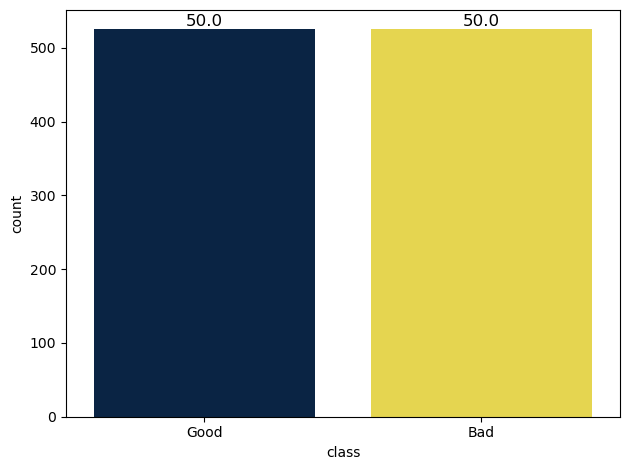

In [ ]:
#%%

# Correlation matrix
tg_dist_2 = sns.countplot(data=df_oversampled, x='class', hue='class', palette='cividis', legend=False)
tg_dist_2.set_xticklabels(['Good','Bad'])

total = sum([p.get_height() for p in tg_dist_2.patches])
for p in tg_dist_2.patches:
    height = p.get_height()
    percentage = 100 * height / total
    tg_dist_2.annotate(f'{percentage:.1f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom', fontsize=12)
    
plt.tight_layout()

if not os.path.exists('./credit_scoring/plots/y_dist_bal'):
    plt.savefig('./credit_scoring/plots/y_dist_bal')
plt.show()

<ipython-input-37-c093d9917def>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  tg_dist_2.set_xticklabels(['Good','Bad'])


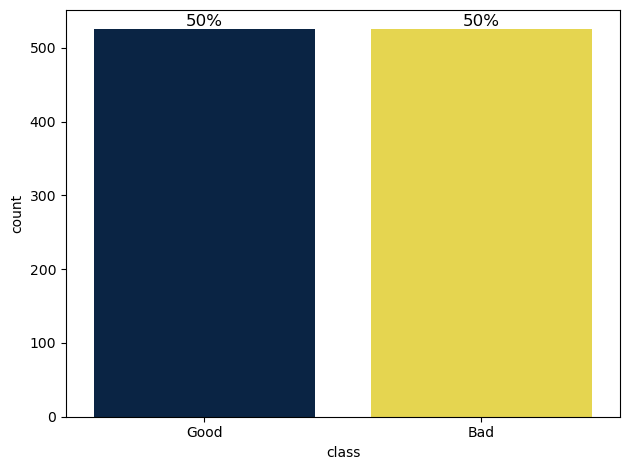

In [ ]:
#%%

# Correlation matrix
tg_dist_2 = sns.countplot(data=df_oversampled, x='class', hue='class', palette='cividis', legend=False)
tg_dist_2.set_xticklabels(['Good','Bad'])

total = sum([p.get_height() for p in tg_dist_2.patches])
for p in tg_dist_2.patches:
    height = p.get_height()
    percentage = 100 * height / total
    tg_dist_2.annotate(f'{percentage:.0f}%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom', fontsize=12)
    
plt.tight_layout()

if not os.path.exists('./credit_scoring/plots/y_dist_bal'):
    plt.savefig('./credit_scoring/plots/y_dist_bal')
plt.show()

<ipython-input-38-d9e13922987e>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  tg_dist.set_xticklabels(['Good', 'Bad'])


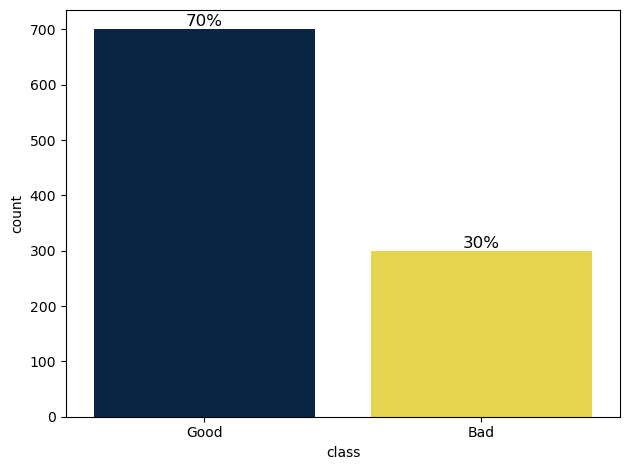

In [ ]:
#%%

# Target distibution
tg_dist = sns.countplot(data=df, x='class', hue='class', palette='cividis', legend=False)
tg_dist.set_xticklabels(['Good', 'Bad'])

total = sum([p.get_height() for p in tg_dist.patches])
for p in tg_dist.patches:
    height = p.get_height()
    percentage = 100 * height / total
    tg_dist.annotate(f'{percentage:.0f}%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom', fontsize=12)
    
plt.tight_layout()

if not os.path.exists('./credit_scoring/plots/y_dist_imbal'):
    plt.savefig('./credit_scoring/plots/y_dist_imbal')
plt.show()

# Since we have an imbalanced dataset with few samples -> Oversampling

<ipython-input-40-c093d9917def>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  tg_dist_2.set_xticklabels(['Good','Bad'])


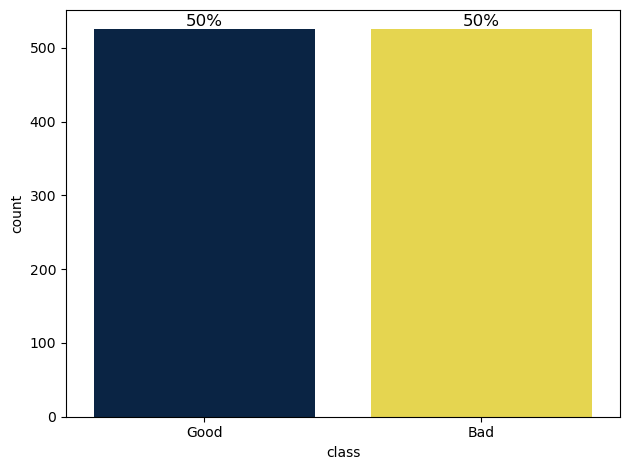

In [ ]:
#%%

# Correlation matrix
tg_dist_2 = sns.countplot(data=df_oversampled, x='class', hue='class', palette='cividis', legend=False)
tg_dist_2.set_xticklabels(['Good','Bad'])

total = sum([p.get_height() for p in tg_dist_2.patches])
for p in tg_dist_2.patches:
    height = p.get_height()
    percentage = 100 * height / total
    tg_dist_2.annotate(f'{percentage:.0f}%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom', fontsize=12)
    
plt.tight_layout()

if not os.path.exists('./credit_scoring/plots/y_dist_bal'):
    plt.savefig('./credit_scoring/plots/y_dist_bal')
plt.show()

In [ ]:
pwd

'c:\\Github\\data_science\\credit_scoring'

In [ ]:
cd ..

c:\Github\data_science


<ipython-input-43-c093d9917def>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  tg_dist_2.set_xticklabels(['Good','Bad'])


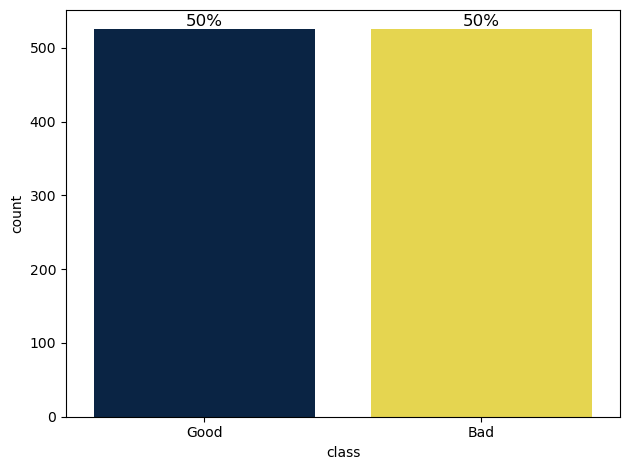

In [ ]:
#%%

# Correlation matrix
tg_dist_2 = sns.countplot(data=df_oversampled, x='class', hue='class', palette='cividis', legend=False)
tg_dist_2.set_xticklabels(['Good','Bad'])

total = sum([p.get_height() for p in tg_dist_2.patches])
for p in tg_dist_2.patches:
    height = p.get_height()
    percentage = 100 * height / total
    tg_dist_2.annotate(f'{percentage:.0f}%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom', fontsize=12)
    
plt.tight_layout()

if not os.path.exists('./credit_scoring/plots/y_dist_bal'):
    plt.savefig('./credit_scoring/plots/y_dist_bal')
plt.show()

<ipython-input-44-d9e13922987e>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  tg_dist.set_xticklabels(['Good', 'Bad'])


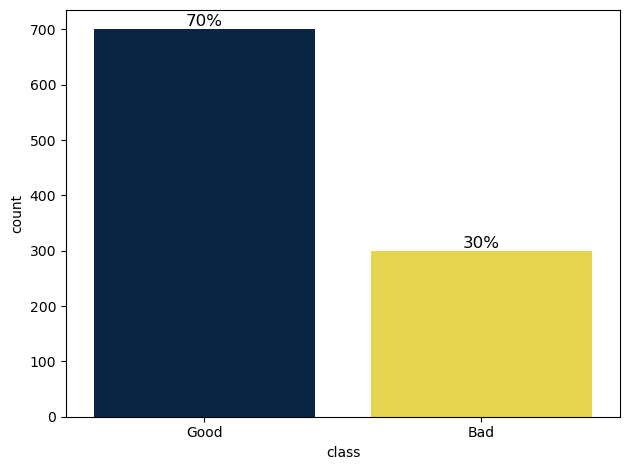

In [ ]:
#%%

# Target distibution
tg_dist = sns.countplot(data=df, x='class', hue='class', palette='cividis', legend=False)
tg_dist.set_xticklabels(['Good', 'Bad'])

total = sum([p.get_height() for p in tg_dist.patches])
for p in tg_dist.patches:
    height = p.get_height()
    percentage = 100 * height / total
    tg_dist.annotate(f'{percentage:.0f}%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom', fontsize=12)
    
plt.tight_layout()

if not os.path.exists('./credit_scoring/plots/y_dist_imbal'):
    plt.savefig('./credit_scoring/plots/y_dist_imbal')
plt.show()

# Since we have an imbalanced dataset with few samples -> Oversampling

In [ ]:
df_oversampled

Attribute2  Attribute5  Attribute8  Attribute11  Attribute13  \
0      -0.750000   -0.386113   -1.000000     0.500000    -0.866667   
1      -0.500000   -0.147502    0.500000     0.500000     0.666667   
2      -0.750000   -0.153640    0.500000     0.000000     0.133333   
3       1.500000    0.163614    0.500000     0.500000    -0.133333   
4       0.500000   -0.374221    0.500000    -0.500000     0.266667   
...          ...         ...         ...          ...          ...   
1045    1.500000    0.412292   -0.500000    -0.729601    -0.383681   
1046   -0.085307    0.063662   -0.292653     0.000000     0.393524   
1047   -0.141341   -0.072618    0.500000    -0.811546    -0.495642   
1048   -0.454028    0.038049    0.408056    -0.500000     0.303444   
1049    2.790637    2.036276    0.500000     0.500000     0.483745   

      Attribute16  Attribute18  Attribute1_A12  Attribute1_A13  \
0               0            0        0.000000             0.0   
1               2            0        0.000000             0.0   
2               0            0        1.000000             0.0   
3               0            0        0.000000             0.0   
4               1            1        0.000000             1.0   
...           ...          ...             ...             ...   
1045            1            0        0.540798             0.0   
1046            0            0        0.414693             0.0   
1047            0            0        0.000000             0.0   
1048            0            0        0.816111             0.0   
1049            0            0        0.000000             0.0   

      Attribute1_A14  ...  Attribute14_A142  Attribute14_A143  \
0           1.000000  ...          0.000000          1.000000   
1           1.000000  ...          0.000000          1.000000   
2           0.000000  ...          0.000000          1.000000   
3           0.000000  ...          0.000000          0.000000   
4           0.000000  ...          0.000000          0.000000   
...              ...  ...               ...               ...   
1045        0.000000  ...          0.540798          0.459202   
1046        0.000000  ...          0.000000          1.000000   
1047        0.000000  ...          0.000000          1.000000   
1048        0.183889  ...          0.000000          1.000000   
1049        0.000000  ...          0.000000          0.290637   

      Attribute15_A152  Attribute15_A153  Attribute17_A172  Attribute17_A173  \
0                  1.0          0.000000          0.000000          1.000000   
1                  1.0          0.000000          0.000000          1.000000   
2                  0.0          0.000000          0.000000          1.000000   
3                  1.0          0.000000          0.000000          1.000000   
4                  1.0          0.000000          1.000000          0.000000   
...                ...               ...               ...               ...   
1045               1.0          0.000000          0.000000          0.459202   
1046               1.0          0.000000          0.000000          1.000000   
1047               1.0          0.000000          0.188454          0.000000   
1048               1.0          0.000000          0.816111          0.000000   
1049               0.0          0.709363          0.000000          0.290637   

      Attribute17_A174  Attribute19_A192  Attribute20_A202  class  
0             0.000000          0.000000               0.0      1  
1             0.000000          1.000000               0.0      1  
2             0.000000          1.000000               0.0      1  
3             0.000000          0.000000               0.0      2  
4             0.000000          0.000000               0.0      2  
...                ...               ...               ...    ...  
1045          0.540798          1.000000               0.0      2  
1046          0.000000          0.414693               0.0      2  
1047          0.00

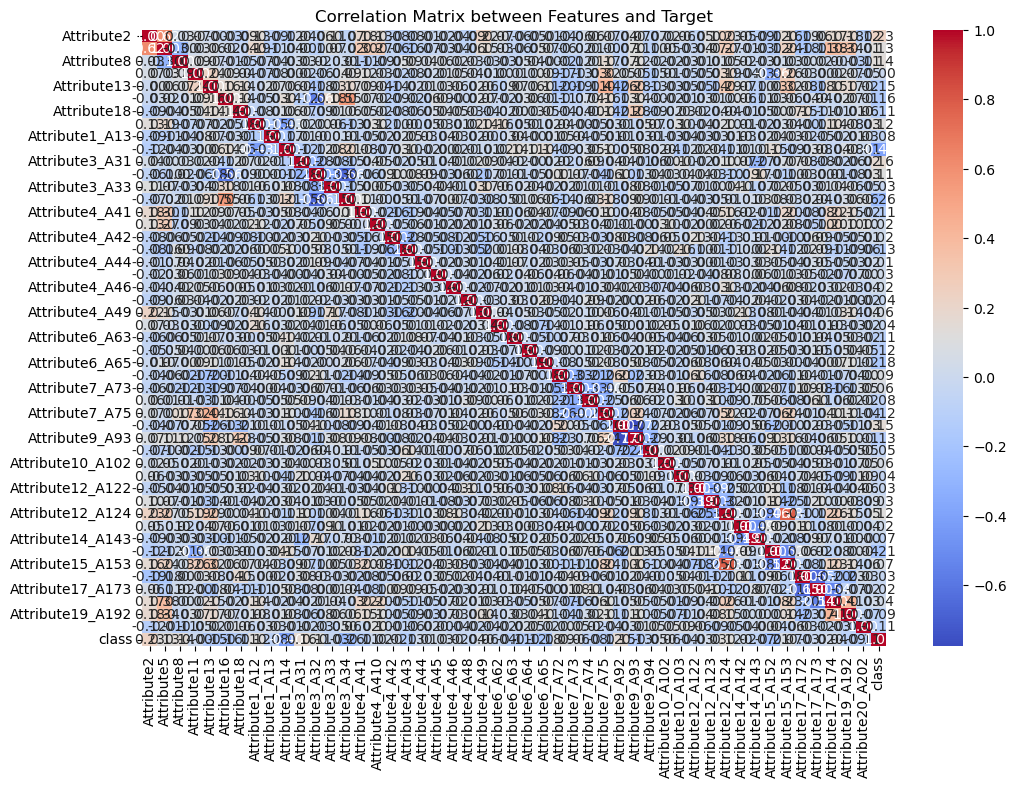

In [ ]:
#%%

# Correlation matrix
correlation_matrix_l = df_oversampled.corr(method='pearson', min_periods=1, numeric_only=False)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_l, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix between Features and Target')
# if not os.path.exists('./census_income/plots/bad_cm.png'):
#     plt.savefig('./census_income/plots/bad_cm.png')
plt.show()

AttributeError: QuadMesh.set() got an unexpected keyword argument 'squeare'

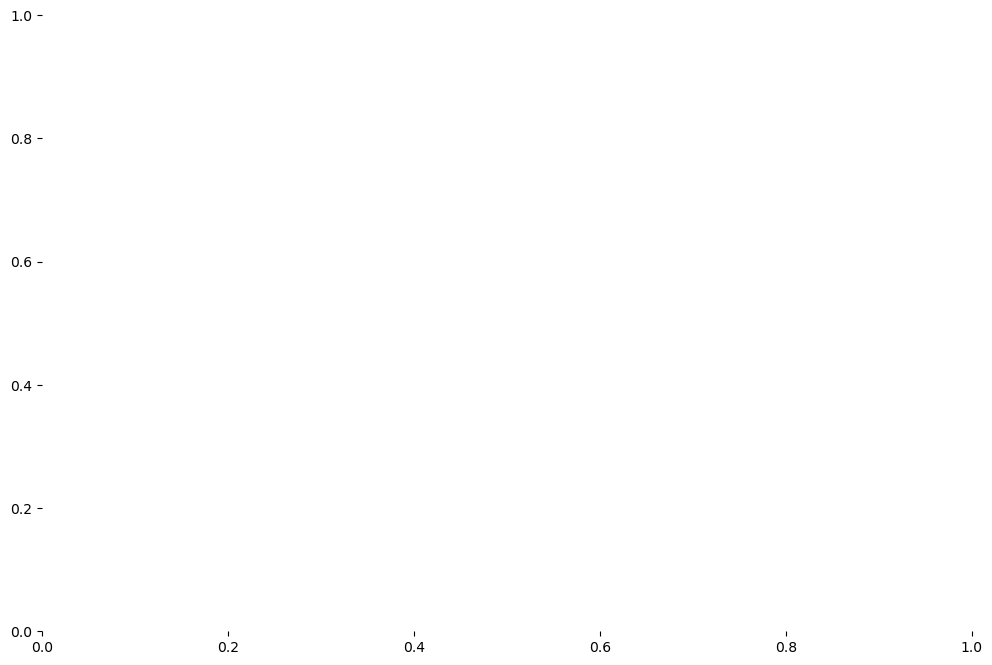

In [ ]:
#%%

# Correlation matrix
correlation_matrix_l = df_oversampled.corr(method='pearson', min_periods=1, numeric_only=False)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_l, annot=False, squeare=True, cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix between Features and Target')
# if not os.path.exists('./census_income/plots/bad_cm.png'):
#     plt.savefig('./census_income/plots/bad_cm.png')
plt.show()

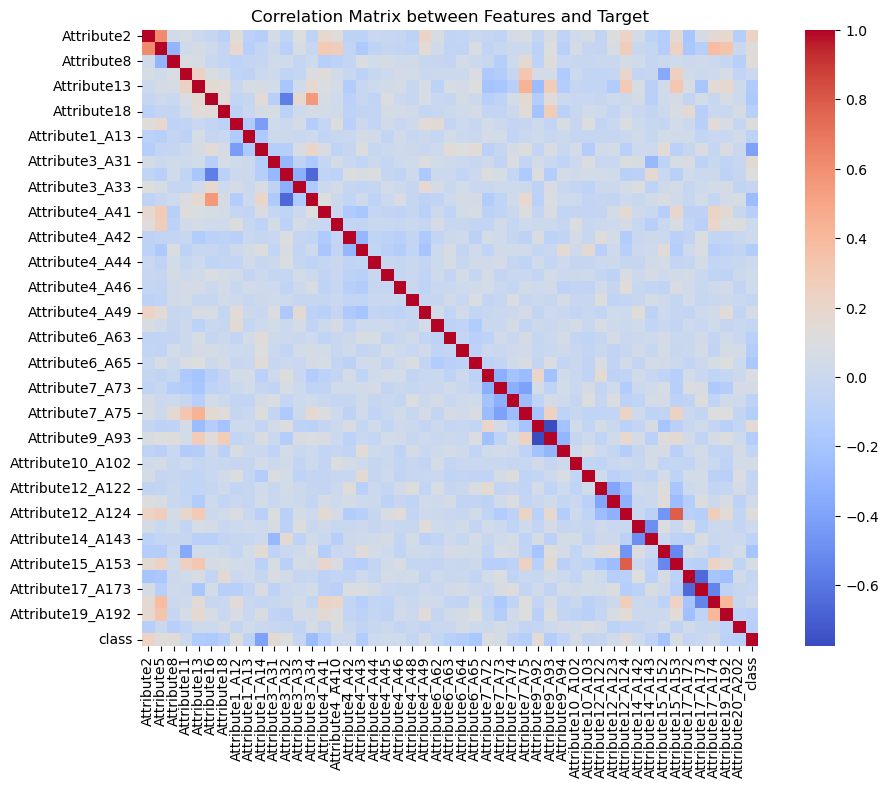

In [ ]:
#%%

# Correlation matrix
correlation_matrix_l = df_oversampled.corr(method='pearson', min_periods=1, numeric_only=False)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_l, annot=False, square=True, cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix between Features and Target')
# if not os.path.exists('./census_income/plots/bad_cm.png'):
#     plt.savefig('./census_income/plots/bad_cm.png')
plt.show()

In [ ]:
correlation_matrix_l

Attribute2  Attribute5  Attribute8  Attribute11  \
Attribute2          1.000000    0.618079    0.032995     0.068431   
Attribute5          0.618079    1.000000   -0.299458     0.026919   
Attribute8          0.032995   -0.299458    1.000000     0.085916   
Attribute11         0.068431    0.026919    0.085916     1.000000   
Attribute13        -0.001142    0.063302    0.068805     0.235726   
Attribute16        -0.026137    0.016178   -0.013179     0.091801   
Attribute18        -0.092394   -0.043967   -0.045157     0.037887   
Attribute1_A12      0.128477    0.185972   -0.072684    -0.067537   
Attribute1_A13     -0.094309   -0.114420   -0.041195    -0.077415   
Attribute1_A14     -0.117755   -0.042065   -0.031160    -0.003575   
Attribute3_A31      0.044502    0.004718    0.028674     0.019948   
Attribute3_A32     -0.062038   -0.095777    0.022813    -0.059781   
Attribute3_A33      0.105806    0.066710   -0.034880    -0.036389   
Attribute3_A34     -0.070056   -0.024356    0.013612     0.093223   
Attribute4_A41      0.176716    0.295260   -0.110805     0.121956   
Attribute4_A410     0.128306    0.268377   -0.086562     0.030650   
Attribute4_A42     -0.080785   -0.058874   -0.046155    -0.023571   
Attribute4_A43     -0.083484   -0.163453    0.086851    -0.080886   
Attribute4_A44     -0.014477   -0.068383    0.036622    -0.021426   
Attribute4_A45     -0.021155   -0.031199    0.061593     0.009200   
Attribute4_A46     -0.037593   -0.042673    0.024573     0.052506   
Attribute4_A48     -0.088351   -0.063857    0.031990     0.037766   
Attribute4_A49      0.222636    0.151036   -0.025521    -0.005364   
Attribute6_A62      0.072819    0.030053   -0.031700     0.003721   
Attribute6_A63     -0.060313   -0.058655   -0.046534     0.005025   
Attribute6_A64     -0.053167   -0.054222    0.041614     0.002175   
Attribute6_A65     -0.012118    0.072141   -0.002675     0.085635   
Attribute7_A72     -0.036884   -0.056276   -0.021811    -0.171604   
Attribute7_A73     -0.057092   -0.021619   -0.118829    -0.133958   
Attribute7_A74      0.055300    0.005996    0.010719    -0.026190   
Attribute7_A75      0.066069    0.003684    0.165542     0.323693   
Attribute9_A92     -0.042238   -0.074993   -0.072770     0.053617   
Attribute9_A93      0.074819    0.110664    0.124725     0.047748   
Attribute9_A94     -0.071935   -0.098668   -0.015013    -0.150381   
Attribute10_A102    0.022828    0.047550   -0.021916     0.011515   
Attribute10_A103    0.057996   -0.028487   -0.025875    -0.046380   
Attribute12_A122   -0.054665   -0.040096   -0.011922    -0.053501   
Attribute12_A123    0.100001    0.073107   -0.010687    -0.033908   
Attribute12_A124    0.226898    0.266587    0.047728     0.192688   
Attribute14_A142    0.049985   -0.008822    0.024280    -0.044003   
Attribute14_A143   -0.085168   -0.034183   -0.027280    -0.027432   
Attribute15_A152   -0.123279   -0.123521   -0.007680    -0.362423   
Attribute15_A153    0.160257    0.236891    0.027005     0.256800   
Attribute17_A172   -0.194006   -0.176148    0.004086     0.029790   
Attribute17_A173    0.062571   -0.111156    0.016073    -0.003967   
Attribute17_A174    0.165505    0.378759    0.000733     0.021823   
Attribute19_A192    0.178413    0.340541   -0.030125     0.068597   
Attribute20_A202   -0.119955   -0.010401   -0.110129    -0.046843   
class               0.230122    0.125340    0.139719    -0.001238   

                  Attribute13  Attribute16  Attribute18  Attribute1_A12  \
Attribute2          -0.001142    -0.026137    -0.092394        0.128477   
Attribute5           0.063302     0.016178    -0.043967        0.185972   
Attribute8           0.068805    -0.013179    -0.045157       -0.072684   
Attribute11          0.235726     0.091801     0.037887       -0.067537   
Attribute13          1.000000     0.163961     0.142814       -0.016628   
Attribute16          0.163961     1.000000     0.136651       -0.047831   
Attribute18          0.142814     0.136651

In [ ]:
correlation_matrix_l['class']

Attribute2          0.230122
Attribute5          0.125340
Attribute8          0.139719
Attribute11        -0.001238
Attribute13        -0.150175
Attribute16        -0.161652
Attribute18        -0.111675
Attribute1_A12      0.115187
Attribute1_A13     -0.080173
Attribute1_A14     -0.404901
Attribute3_A31      0.163737
Attribute3_A32      0.106539
Attribute3_A33     -0.030070
Attribute3_A34     -0.259251
Attribute4_A41     -0.112898
Attribute4_A410     0.015375
Attribute4_A42      0.018266
Attribute4_A43     -0.132665
Attribute4_A44      0.009086
Attribute4_A45      0.025566
Attribute4_A46      0.022501
Attribute4_A48     -0.039634
Attribute4_A49      0.055757
Attribute6_A62     -0.039340
Attribute6_A63     -0.105729
Attribute6_A64     -0.123633
Attribute6_A65     -0.175093
Attribute7_A72      0.088670
Attribute7_A73      0.058096
Attribute7_A74     -0.081073
Attribute7_A75     -0.117920
Attribute9_A92      0.148955
Attribute9_A93     -0.125495
Attribute9_A94     -0.050017
Attribute10_A1

In [ ]:
df.loc['class']

KeyError: 'class'

In [ ]:
correlation_matrix_l.loc['class']

Attribute2          0.230122
Attribute5          0.125340
Attribute8          0.139719
Attribute11        -0.001238
Attribute13        -0.150175
Attribute16        -0.161652
Attribute18        -0.111675
Attribute1_A12      0.115187
Attribute1_A13     -0.080173
Attribute1_A14     -0.404901
Attribute3_A31      0.163737
Attribute3_A32      0.106539
Attribute3_A33     -0.030070
Attribute3_A34     -0.259251
Attribute4_A41     -0.112898
Attribute4_A410     0.015375
Attribute4_A42      0.018266
Attribute4_A43     -0.132665
Attribute4_A44      0.009086
Attribute4_A45      0.025566
Attribute4_A46      0.022501
Attribute4_A48     -0.039634
Attribute4_A49      0.055757
Attribute6_A62     -0.039340
Attribute6_A63     -0.105729
Attribute6_A64     -0.123633
Attribute6_A65     -0.175093
Attribute7_A72      0.088670
Attribute7_A73      0.058096
Attribute7_A74     -0.081073
Attribute7_A75     -0.117920
Attribute9_A92      0.148955
Attribute9_A93     -0.125495
Attribute9_A94     -0.050017
Attribute10_A1

In [ ]:
correlation_matrix_l.loc['class'].shape

(49,)

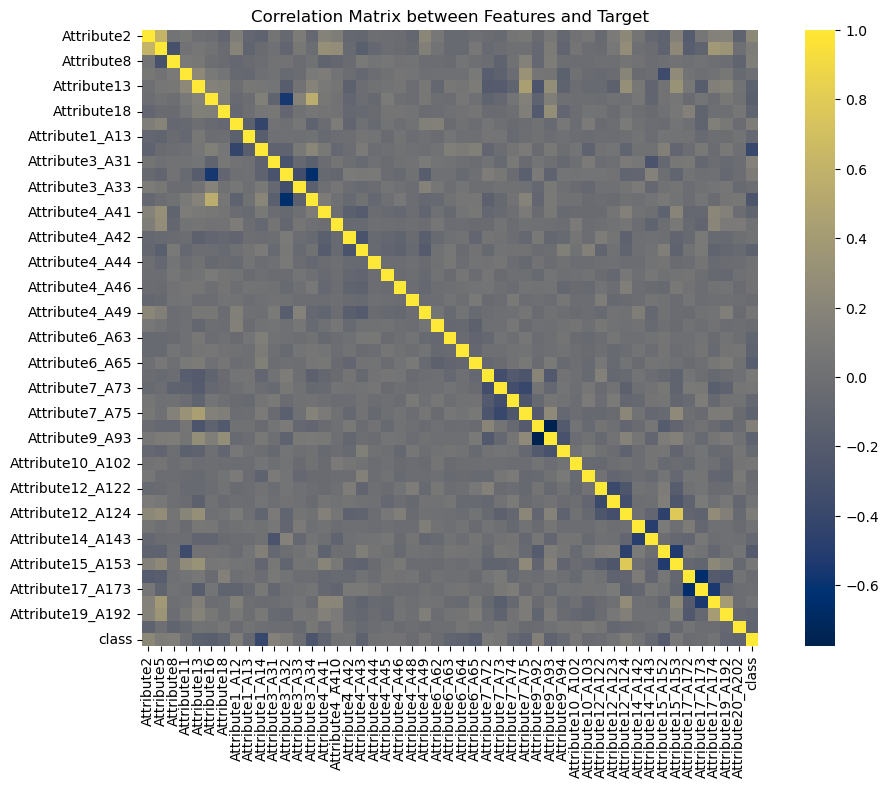

In [ ]:
#%%

# Correlation matrix
correlation_matrix_l = df_oversampled.corr(method='pearson', min_periods=1, numeric_only=False)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_l, annot=False, square=True, cmap='cividis', cbar=True)
plt.title('Correlation Matrix between Features and Target')
if not os.path.exists('./census_income/plots/bad_cm.png'):
    plt.savefig('./census_income/plots/bad_cm.png')
plt.show()

In [ ]:
#%%

# Correlation matrix
correlation_matrix_l = df_oversampled.corr(method='pearson', min_periods=1, numeric_only=False)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_l, annot=False, square=True, cmap='oranges', cbar=True)
plt.title('Correlation Matrix between Features and Target')
if not os.path.exists('./census_income/plots/bad_cm.png'):
    plt.savefig('./census_income/plots/bad_cm.png')
plt.show()

KeyError: "'oranges' is not a known colormap name"

<Figure size 1200x800 with 0 Axes>

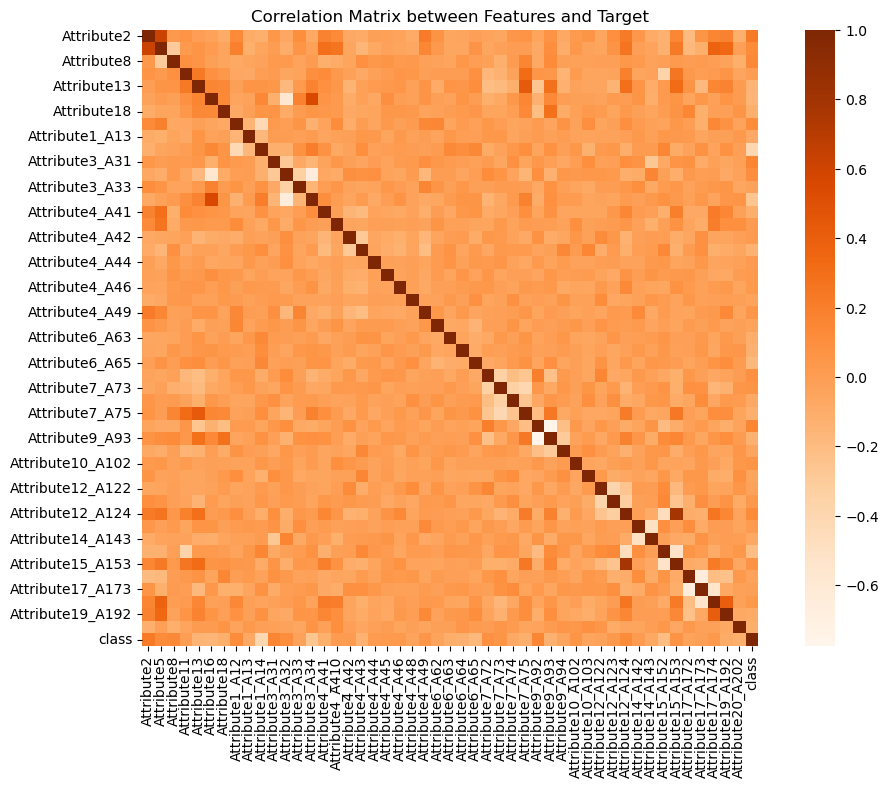

In [ ]:
#%%

# Correlation matrix
correlation_matrix_l = df_oversampled.corr(method='pearson', min_periods=1, numeric_only=False)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_l, annot=False, square=True, cmap='Oranges', cbar=True)
plt.title('Correlation Matrix between Features and Target')
if not os.path.exists('./census_income/plots/bad_cm.png'):
    plt.savefig('./census_income/plots/bad_cm.png')
plt.show()

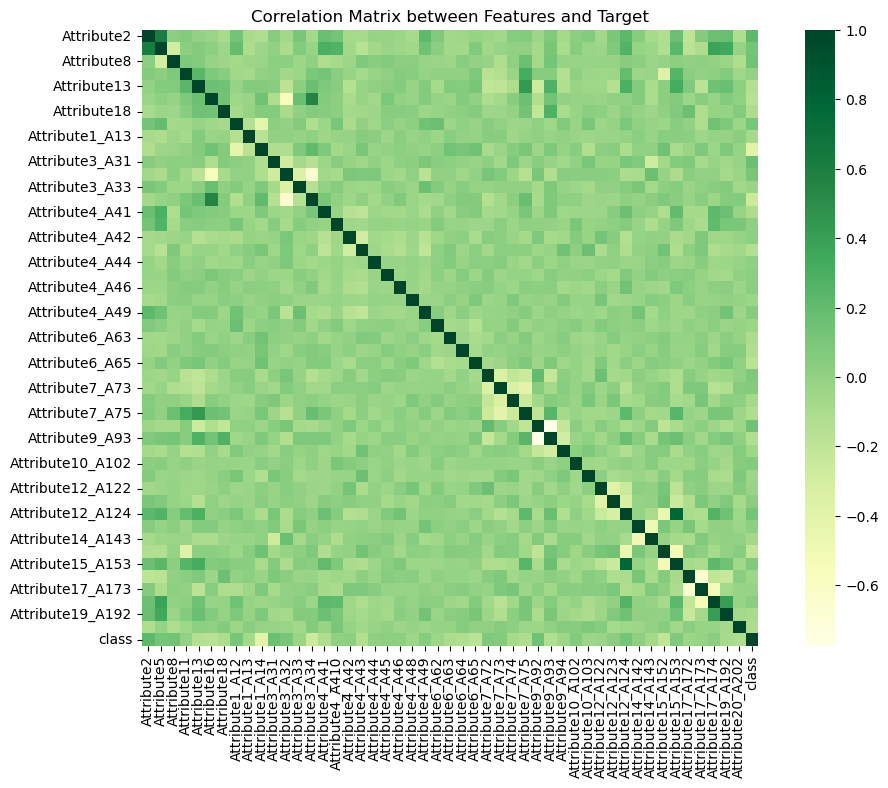

In [ ]:
#%%

# Correlation matrix
correlation_matrix_l = df_oversampled.corr(method='pearson', min_periods=1, numeric_only=False)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_l, annot=False, square=True, cmap='YlGn', cbar=True)
plt.title('Correlation Matrix between Features and Target')
if not os.path.exists('./census_income/plots/bad_cm.png'):
    plt.savefig('./census_income/plots/bad_cm.png')
plt.show()

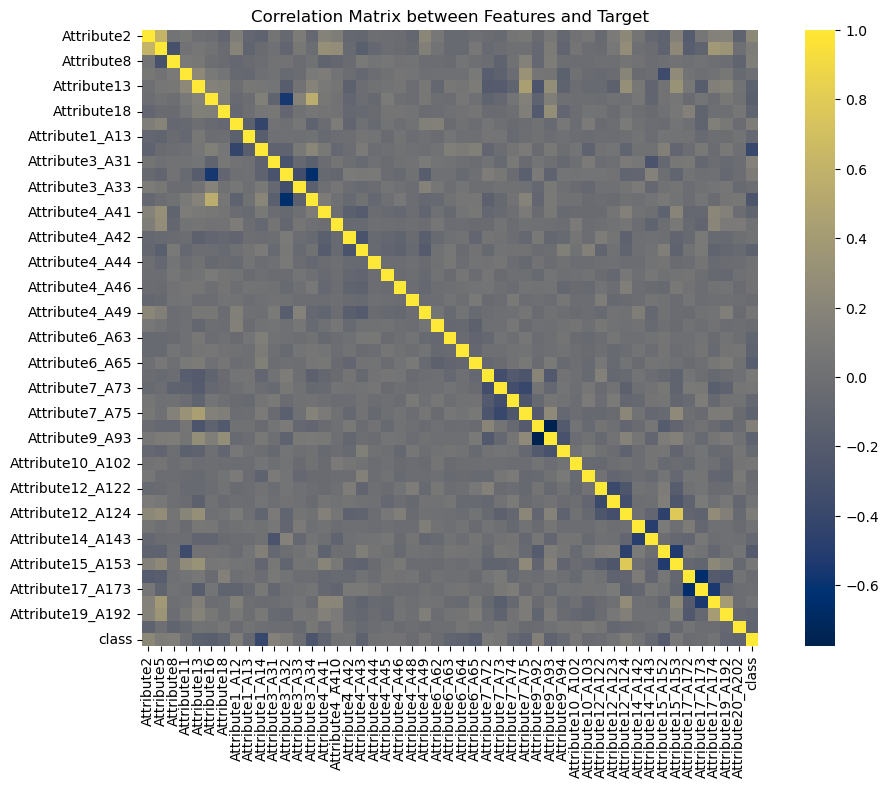

In [ ]:
#%%

# Correlation matrix
correlation_matrix_l = df_oversampled.corr(method='pearson', min_periods=1, numeric_only=False)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_l, annot=False, square=True, cmap='cividis', cbar=True)
plt.title('Correlation Matrix between Features and Target')
if not os.path.exists('./census_income/plots/bad_cm.png'):
    plt.savefig('./census_income/plots/bad_cm.png')
plt.show()

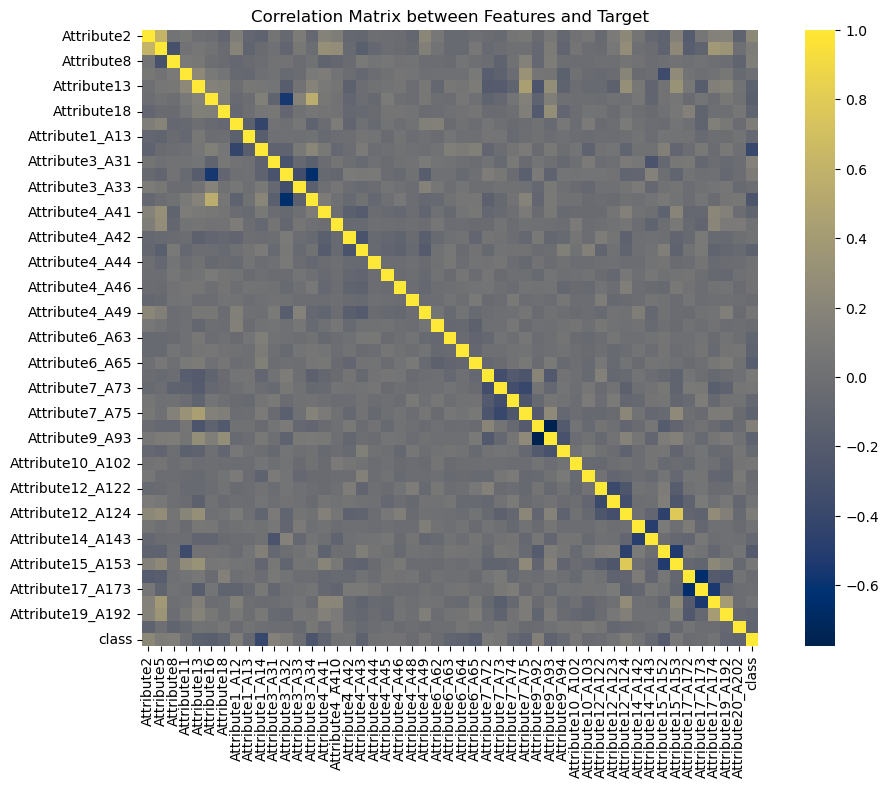

In [ ]:
#%%

# Correlation matrix
correlation_matrix_l = df_oversampled.corr(method='pearson', min_periods=1, numeric_only=False)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_l, annot=False, square=True, cmap='cividis', cbar=True)
plt.title('Correlation Matrix between Features and Target')
if not os.path.exists('./credit_scoring/plots/bad_cm.png'):
    plt.savefig('./credit_scoring/plots/bad_cm.png')
plt.show()

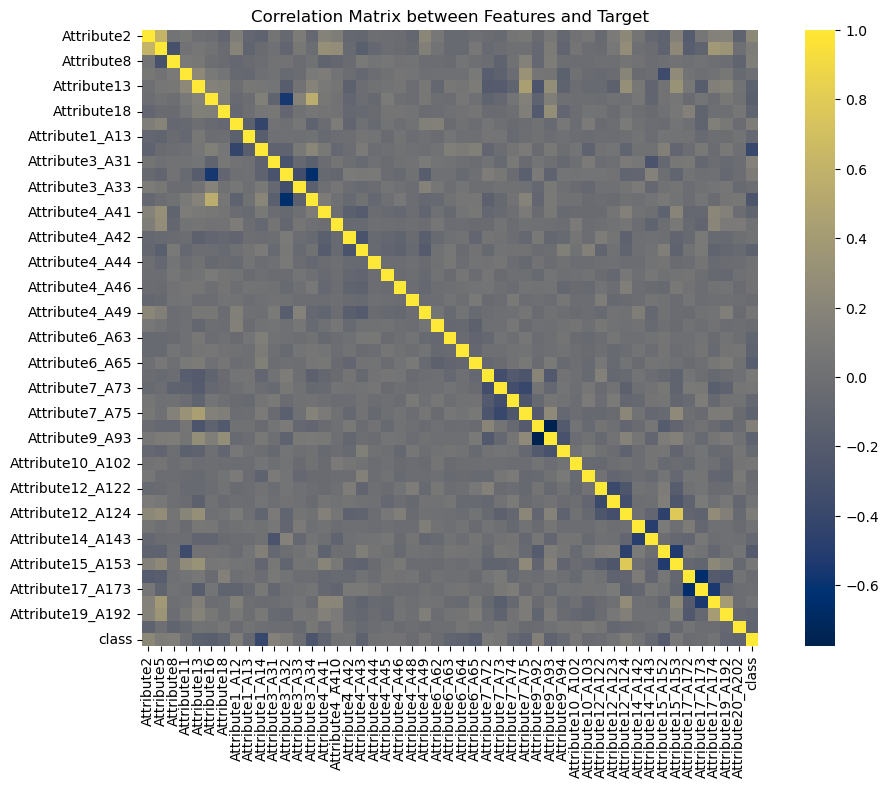

In [ ]:
#%%

# Correlation matrix
correlation_matrix_l = df_oversampled.corr(method='pearson', min_periods=1, numeric_only=False)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_l, annot=False, square=True, cmap='cividis', cbar=True)
plt.title('Correlation Matrix between Features and Target')
if not os.path.exists('./credit_scoring/plots/correlation_matrix.png'):
    plt.savefig('./credit_scoring/plots/correlation_matrix.png')
plt.show()

In [ ]:
df_oversampled[df_oversampled['class']>0.2]

Attribute2  Attribute5  Attribute8  Attribute11  Attribute13  \
0      -0.750000   -0.386113   -1.000000     0.500000    -0.866667   
1      -0.500000   -0.147502    0.500000     0.500000     0.666667   
2      -0.750000   -0.153640    0.500000     0.000000     0.133333   
3       1.500000    0.163614    0.500000     0.500000    -0.133333   
4       0.500000   -0.374221    0.500000    -0.500000     0.266667   
...          ...         ...         ...          ...          ...   
1045    1.500000    0.412292   -0.500000    -0.729601    -0.383681   
1046   -0.085307    0.063662   -0.292653     0.000000     0.393524   
1047   -0.141341   -0.072618    0.500000    -0.811546    -0.495642   
1048   -0.454028    0.038049    0.408056    -0.500000     0.303444   
1049    2.790637    2.036276    0.500000     0.500000     0.483745   

      Attribute16  Attribute18  Attribute1_A12  Attribute1_A13  \
0               0            0        0.000000             0.0   
1               2            0        0.000000             0.0   
2               0            0        1.000000             0.0   
3               0            0        0.000000             0.0   
4               1            1        0.000000             1.0   
...           ...          ...             ...             ...   
1045            1            0        0.540798             0.0   
1046            0            0        0.414693             0.0   
1047            0            0        0.000000             0.0   
1048            0            0        0.816111             0.0   
1049            0            0        0.000000             0.0   

      Attribute1_A14  ...  Attribute14_A142  Attribute14_A143  \
0           1.000000  ...          0.000000          1.000000   
1           1.000000  ...          0.000000          1.000000   
2           0.000000  ...          0.000000          1.000000   
3           0.000000  ...          0.000000          0.000000   
4           0.000000  ...          0.000000          0.000000   
...              ...  ...               ...               ...   
1045        0.000000  ...          0.540798          0.459202   
1046        0.000000  ...          0.000000          1.000000   
1047        0.000000  ...          0.000000          1.000000   
1048        0.183889  ...          0.000000          1.000000   
1049        0.000000  ...          0.000000          0.290637   

      Attribute15_A152  Attribute15_A153  Attribute17_A172  Attribute17_A173  \
0                  1.0          0.000000          0.000000          1.000000   
1                  1.0          0.000000          0.000000          1.000000   
2                  0.0          0.000000          0.000000          1.000000   
3                  1.0          0.000000          0.000000          1.000000   
4                  1.0          0.000000          1.000000          0.000000   
...                ...               ...               ...               ...   
1045               1.0          0.000000          0.000000          0.459202   
1046               1.0          0.000000          0.000000          1.000000   
1047               1.0          0.000000          0.188454          0.000000   
1048               1.0          0.000000          0.816111          0.000000   
1049               0.0          0.709363          0.000000          0.290637   

      Attribute17_A174  Attribute19_A192  Attribute20_A202  class  
0             0.000000          0.000000               0.0      1  
1             0.000000          1.000000               0.0      1  
2             0.000000          1.000000               0.0      1  
3             0.000000          0.000000               0.0      2  
4             0.000000          0.000000               0.0      2  
...                ...               ...               ...    ...  
1045          0.540798          1.000000               0.0      2  
1046          0.000000          0.414693               0.0      2  
1047          0.00

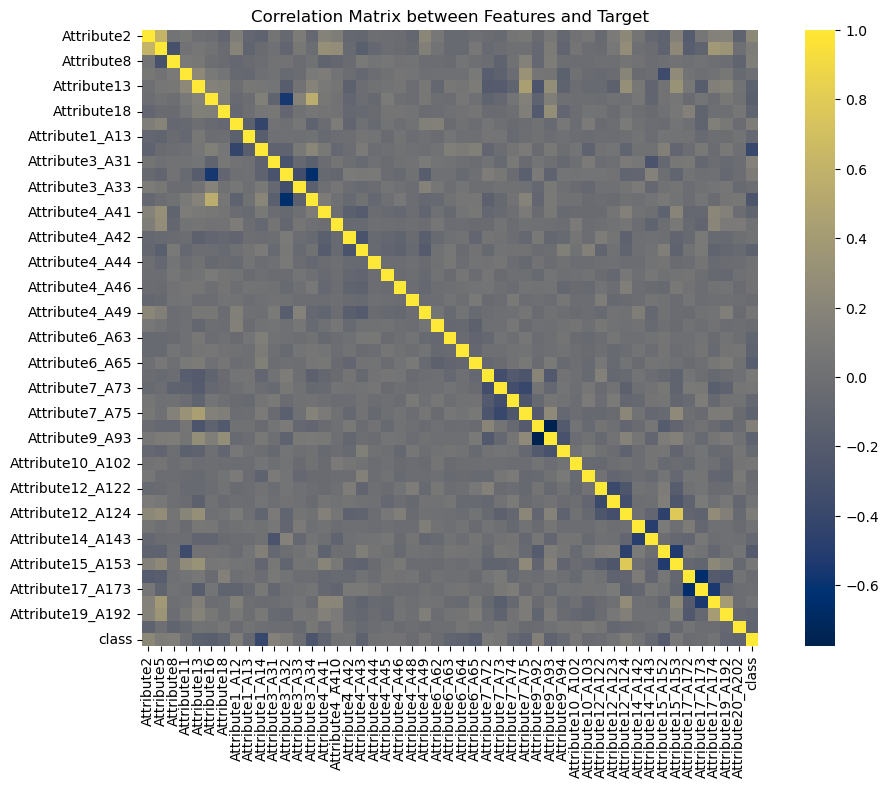

In [ ]:
#%%

# Correlation matrix
correlation_matrix_l = df_oversampled.corr(method='pearson', min_periods=1, numeric_only=False)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_l, annot=False, square=True, cmap='cividis', cbar=True)
plt.title('Correlation Matrix between Features and Target')
if not os.path.exists('./credit_scoring/plots/correlation_matrix.png'):
    plt.savefig('./credit_scoring/plots/correlation_matrix.png')
plt.show()

sub_df_oversampled = pd.concat([df_oversampled[df_oversampled['class']>0.2],
                               df_oversampled[df_oversampled['class']<0.2]])

In [ ]:
#%%

sub_df_oversampled = pd.concat([df_oversampled[df_oversampled['class']>0.2],
                               df_oversampled[df_oversampled['class']<0.2]])
print(sub_df_oversampled.count())

Attribute2          1050
Attribute5          1050
Attribute8          1050
Attribute11         1050
Attribute13         1050
Attribute16         1050
Attribute18         1050
Attribute1_A12      1050
Attribute1_A13      1050
Attribute1_A14      1050
Attribute3_A31      1050
Attribute3_A32      1050
Attribute3_A33      1050
Attribute3_A34      1050
Attribute4_A41      1050
Attribute4_A410     1050
Attribute4_A42      1050
Attribute4_A43      1050
Attribute4_A44      1050
Attribute4_A45      1050
Attribute4_A46      1050
Attribute4_A48      1050
Attribute4_A49      1050
Attribute6_A62      1050
Attribute6_A63      1050
Attribute6_A64      1050
Attribute6_A65      1050
Attribute7_A72      1050
Attribute7_A73      1050
Attribute7_A74      1050
Attribute7_A75      1050
Attribute9_A92      1050
Attribute9_A93      1050
Attribute9_A94      1050
Attribute10_A102    1050
Attribute10_A103    1050
Attribute12_A122    1050
Attribute12_A123    1050
Attribute12_A124    1050
Attribute14_A142    1050


In [ ]:
#%%

sub_df_oversampled = pd.concat([df_oversampled[df_oversampled['class']>0.2],
                               df_oversampled[df_oversampled['class']<0.2]])
print(sub_df_oversampled.count().mean())

1050.0


In [ ]:
#%%

print("Positive Correlation between features and class (Higher than 0.2):")
for feature in correlation_matrix_l.columns:
    if feature != 'class' and correlation_matrix_l.loc[feature, 'class'] > 0.2:
        print(f"{feature}: {correlation_matrix_l.loc[feature, 'class']:.2f}")

# Print negative correlation features (Lower than -0.4)
print("Negative Correlation between features and class (Lower than -0.2):")
for feature in correlation_matrix_l.columns:
    if feature != 'class' and correlation_matrix_l.loc[feature, 'class'] < -0.2:
        print(f"{feature}: {correlation_matrix_l.loc[feature, 'class']:.2f}")

Positive Correlation between features and class (Higher than 0.2):
Attribute2: 0.23
Negative Correlation between features and class (Lower than -0.2):
Attribute1_A14: -0.40
Attribute3_A34: -0.26
Attribute15_A152: -0.21


In [ ]:
correlation_matrix_l

Attribute2  Attribute5  Attribute8  Attribute11  \
Attribute2          1.000000    0.618079    0.032995     0.068431   
Attribute5          0.618079    1.000000   -0.299458     0.026919   
Attribute8          0.032995   -0.299458    1.000000     0.085916   
Attribute11         0.068431    0.026919    0.085916     1.000000   
Attribute13        -0.001142    0.063302    0.068805     0.235726   
Attribute16        -0.026137    0.016178   -0.013179     0.091801   
Attribute18        -0.092394   -0.043967   -0.045157     0.037887   
Attribute1_A12      0.128477    0.185972   -0.072684    -0.067537   
Attribute1_A13     -0.094309   -0.114420   -0.041195    -0.077415   
Attribute1_A14     -0.117755   -0.042065   -0.031160    -0.003575   
Attribute3_A31      0.044502    0.004718    0.028674     0.019948   
Attribute3_A32     -0.062038   -0.095777    0.022813    -0.059781   
Attribute3_A33      0.105806    0.066710   -0.034880    -0.036389   
Attribute3_A34     -0.070056   -0.024356    0.013612     0.093223   
Attribute4_A41      0.176716    0.295260   -0.110805     0.121956   
Attribute4_A410     0.128306    0.268377   -0.086562     0.030650   
Attribute4_A42     -0.080785   -0.058874   -0.046155    -0.023571   
Attribute4_A43     -0.083484   -0.163453    0.086851    -0.080886   
Attribute4_A44     -0.014477   -0.068383    0.036622    -0.021426   
Attribute4_A45     -0.021155   -0.031199    0.061593     0.009200   
Attribute4_A46     -0.037593   -0.042673    0.024573     0.052506   
Attribute4_A48     -0.088351   -0.063857    0.031990     0.037766   
Attribute4_A49      0.222636    0.151036   -0.025521    -0.005364   
Attribute6_A62      0.072819    0.030053   -0.031700     0.003721   
Attribute6_A63     -0.060313   -0.058655   -0.046534     0.005025   
Attribute6_A64     -0.053167   -0.054222    0.041614     0.002175   
Attribute6_A65     -0.012118    0.072141   -0.002675     0.085635   
Attribute7_A72     -0.036884   -0.056276   -0.021811    -0.171604   
Attribute7_A73     -0.057092   -0.021619   -0.118829    -0.133958   
Attribute7_A74      0.055300    0.005996    0.010719    -0.026190   
Attribute7_A75      0.066069    0.003684    0.165542     0.323693   
Attribute9_A92     -0.042238   -0.074993   -0.072770     0.053617   
Attribute9_A93      0.074819    0.110664    0.124725     0.047748   
Attribute9_A94     -0.071935   -0.098668   -0.015013    -0.150381   
Attribute10_A102    0.022828    0.047550   -0.021916     0.011515   
Attribute10_A103    0.057996   -0.028487   -0.025875    -0.046380   
Attribute12_A122   -0.054665   -0.040096   -0.011922    -0.053501   
Attribute12_A123    0.100001    0.073107   -0.010687    -0.033908   
Attribute12_A124    0.226898    0.266587    0.047728     0.192688   
Attribute14_A142    0.049985   -0.008822    0.024280    -0.044003   
Attribute14_A143   -0.085168   -0.034183   -0.027280    -0.027432   
Attribute15_A152   -0.123279   -0.123521   -0.007680    -0.362423   
Attribute15_A153    0.160257    0.236891    0.027005     0.256800   
Attribute17_A172   -0.194006   -0.176148    0.004086     0.029790   
Attribute17_A173    0.062571   -0.111156    0.016073    -0.003967   
Attribute17_A174    0.165505    0.378759    0.000733     0.021823   
Attribute19_A192    0.178413    0.340541   -0.030125     0.068597   
Attribute20_A202   -0.119955   -0.010401   -0.110129    -0.046843   
class               0.230122    0.125340    0.139719    -0.001238   

                  Attribute13  Attribute16  Attribute18  Attribute1_A12  \
Attribute2          -0.001142    -0.026137    -0.092394        0.128477   
Attribute5           0.063302     0.016178    -0.043967        0.185972   
Attribute8           0.068805    -0.013179    -0.045157       -0.072684   
Attribute11          0.235726     0.091801     0.037887       -0.067537   
Attribute13          1.000000     0.163961     0.142814       -0.016628   
Attribute16          0.163961     1.000000     0.136651       -0.047831   
Attribute18          0.142814     0.136651

In [ ]:
#%%

print("Positive Correlation between features and class (Higher than 0.2):")
pos_cor_feat = []
for feature in correlation_matrix_l.columns:
    if feature != 'class' and correlation_matrix_l.loc[feature, 'class'] > 0.2:
        print(f"{feature}: {correlation_matrix_l.loc[feature, 'class']:.2f}")
        pos_cor_feat.append(correlation_matrix_l.loc[feature, 'class'])

neg_cor_feat = []
print("Negative Correlation between features and class (Lower than -0.2):")
for feature in correlation_matrix_l.columns:
    if feature != 'class' and correlation_matrix_l.loc[feature, 'class'] < -0.2:
        print(f"{feature}: {correlation_matrix_l.loc[feature, 'class']:.2f}")
        neg_cor_feat.append(correlation_matrix_l.loc[feature, 'class'])

Positive Correlation between features and class (Higher than 0.2):
Attribute2: 0.23
Negative Correlation between features and class (Lower than -0.2):
Attribute1_A14: -0.40
Attribute3_A34: -0.26
Attribute15_A152: -0.21


In [ ]:
#%%

print("Positive Correlation between features and class (Higher than 0.2):")
pos_cor_feat = []
for feature in correlation_matrix_l.columns:
    if feature != 'class' and correlation_matrix_l.loc[feature, 'class'] > 0.2:
        print(f"{feature}: {correlation_matrix_l.loc[feature, 'class']:.2f}")
        pos_cor_feat.append(correlation_matrix_l.loc[feature, 'class'])

neg_cor_feat = []
print("Negative Correlation between features and class (Lower than -0.2):")
for feature in correlation_matrix_l.columns:
    if feature != 'class' and correlation_matrix_l.loc[feature, 'class'] < -0.2:
        print(f"{feature}: {correlation_matrix_l.loc[feature, 'class']:.2f}")
        neg_cor_feat.append(feature)

Positive Correlation between features and class (Higher than 0.2):
Attribute2: 0.23
Negative Correlation between features and class (Lower than -0.2):
Attribute1_A14: -0.40
Attribute3_A34: -0.26
Attribute15_A152: -0.21


In [ ]:
neg_cor_feat

['Attribute1_A14', 'Attribute3_A34', 'Attribute15_A152']

In [ ]:
#%%

print("Positive Correlation between features and class (Higher than 0.2):")
pos_cor_feat = []
for feature in correlation_matrix_l.columns:
    if feature != 'class' and correlation_matrix_l.loc[feature, 'class'] > 0.2:
        print(f"{feature}: {correlation_matrix_l.loc[feature, 'class']:.2f}")
        pos_cor_feat.append(feature)

neg_cor_feat = []
print("Negative Correlation between features and class (Lower than -0.2):")
for feature in correlation_matrix_l.columns:
    if feature != 'class' and correlation_matrix_l.loc[feature, 'class'] < -0.2:
        print(f"{feature}: {correlation_matrix_l.loc[feature, 'class']:.2f}")
        neg_cor_feat.append(feature)

Positive Correlation between features and class (Higher than 0.2):
Attribute2: 0.23
Negative Correlation between features and class (Lower than -0.2):
Attribute1_A14: -0.40
Attribute3_A34: -0.26
Attribute15_A152: -0.21


TypeError: 'Axes' object is not subscriptable

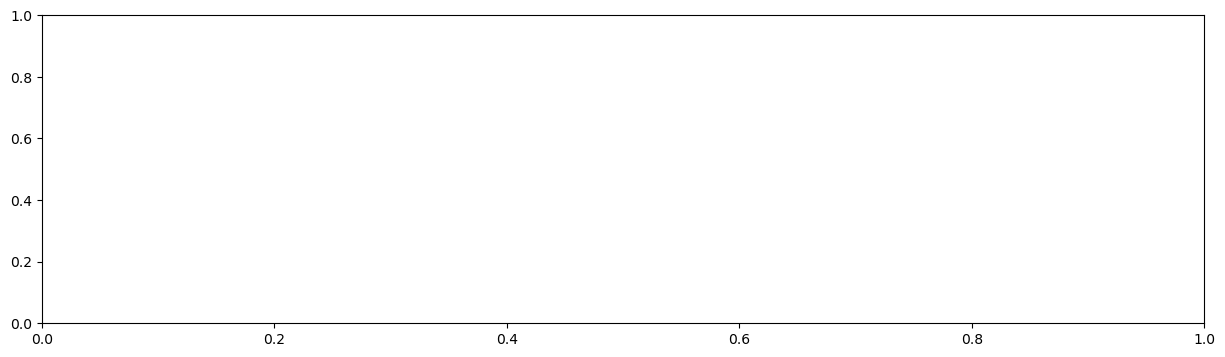

In [ ]:
#%%

# Correlation inspection
f, axes = plt.subplots(ncols=len(pos_cor_feat), figsize=(15,4))

for i, feature in enumerate(pos_cor_feat):
    sns.boxplot(x="Class", y="V10", data=df_oversampled, ax=axes[i])
    axes[i].set_title(f'{feature} vs Class Positive Correlation')

In [ ]:
for i, feature in enumerate(pos_cor_feat):
    print (i)

0


In [ ]:
#%%

# Correlation inspection

sns.boxplot(x="Class", y=pos_cor_feat[0], data=df_oversampled)
plt.set_title(f'{pos_cor_feat[0]} vs Class Positive Correlation')
plt.tight_layout()
plt.show()

f, axes = plt.subplots(ncols=len(neg_cor_feat), figsize=(15,4))

for i, feature in enumerate(neg_cor_feat):
    sns.boxplot(x="Class", y="V10", data=df_oversampled, ax=axes[i])
    axes[i].set_title(f'{feature} vs Class Positive Correlation')

plt.tight_layout()
plt.show()

ValueError: Could not interpret value `Class` for `x`. An entry with this name does not appear in `data`.

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_title'

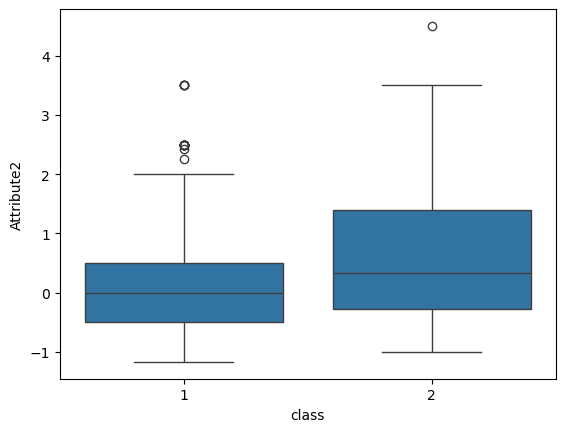

In [ ]:
#%%

# Correlation inspection

sns.boxplot(x="class", y=pos_cor_feat[0], data=df_oversampled)
plt.set_title(f'{pos_cor_feat[0]} vs Class Positive Correlation')
plt.tight_layout()
plt.show()

f, axes = plt.subplots(ncols=len(neg_cor_feat), figsize=(15,4))

for i, feature in enumerate(neg_cor_feat):
    sns.boxplot(x="Class", y="V10", data=df_oversampled, ax=axes[i])
    axes[i].set_title(f'{feature} vs Class Positive Correlation')

plt.tight_layout()
plt.show()

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_title'

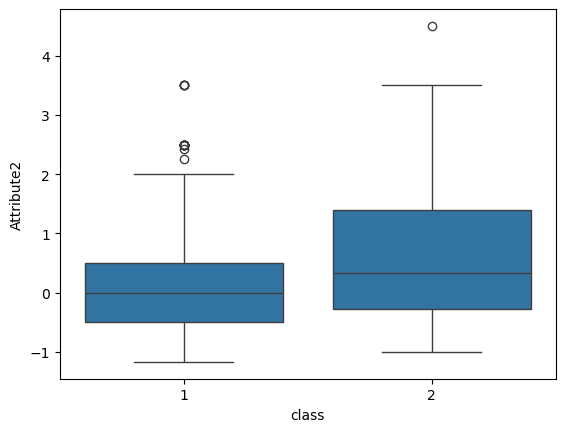

In [ ]:
#%%

# Correlation inspection

sns.boxplot(x="class", y=pos_cor_feat[0], data=df_oversampled)
plt.set_title(f'{pos_cor_feat[0]} vs Class Positive Correlation')
plt.tight_layout()
plt.show()

f, axes = plt.subplots(ncols=len(neg_cor_feat), figsize=(15,4))

for i, feature in enumerate(neg_cor_feat):
    sns.boxplot(x="class", y=f"{feature}", data=df_oversampled, ax=axes[i])
    axes[i].set_title(f'{feature} vs Class Positive Correlation')

plt.tight_layout()
plt.show()

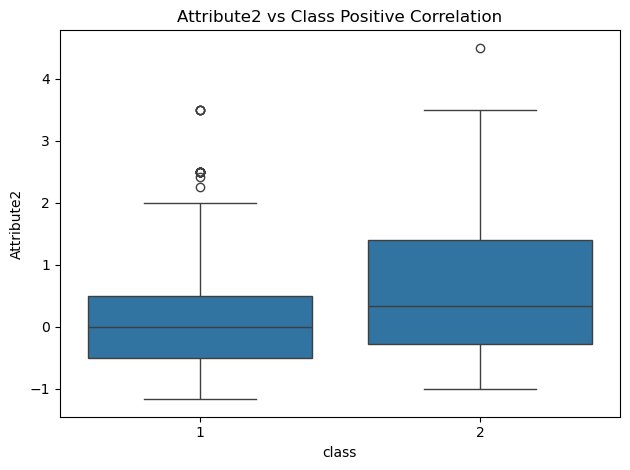

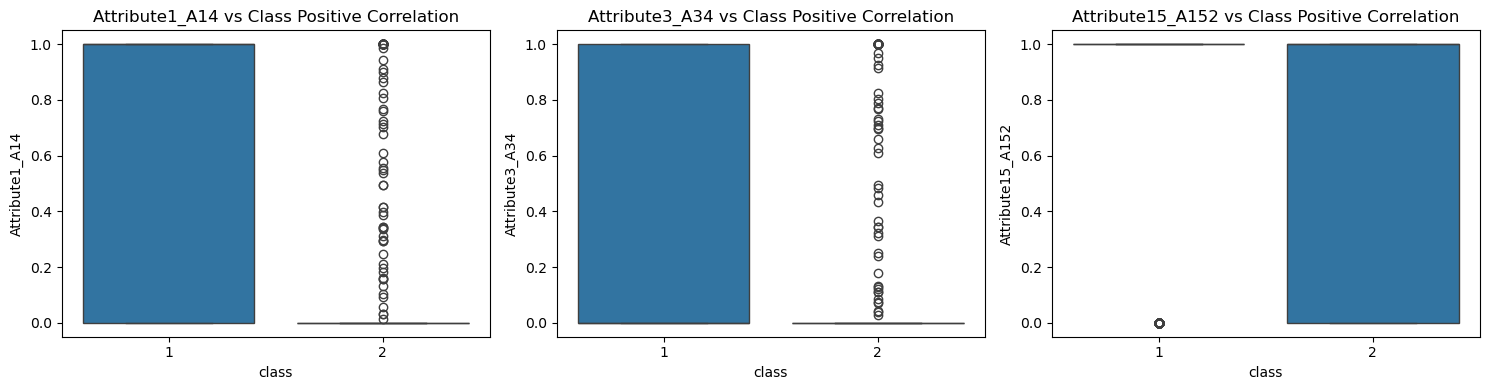

In [ ]:
#%%

# Correlation inspection

sns.boxplot(x="class", y=pos_cor_feat[0], data=df_oversampled)
plt.title(f'{pos_cor_feat[0]} vs Class Positive Correlation')
plt.tight_layout()
plt.show()

f, axes = plt.subplots(ncols=len(neg_cor_feat), figsize=(15,4))

for i, feature in enumerate(neg_cor_feat):
    sns.boxplot(x="class", y=f"{feature}", data=df_oversampled, ax=axes[i])
    axes[i].set_title(f'{feature} vs Class Positive Correlation')

plt.tight_layout()
plt.show()

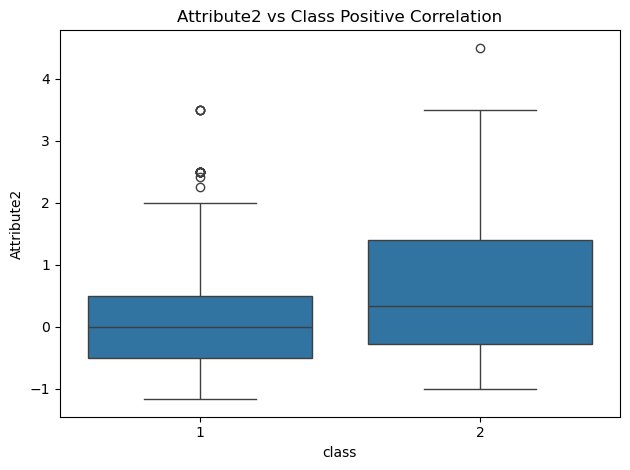

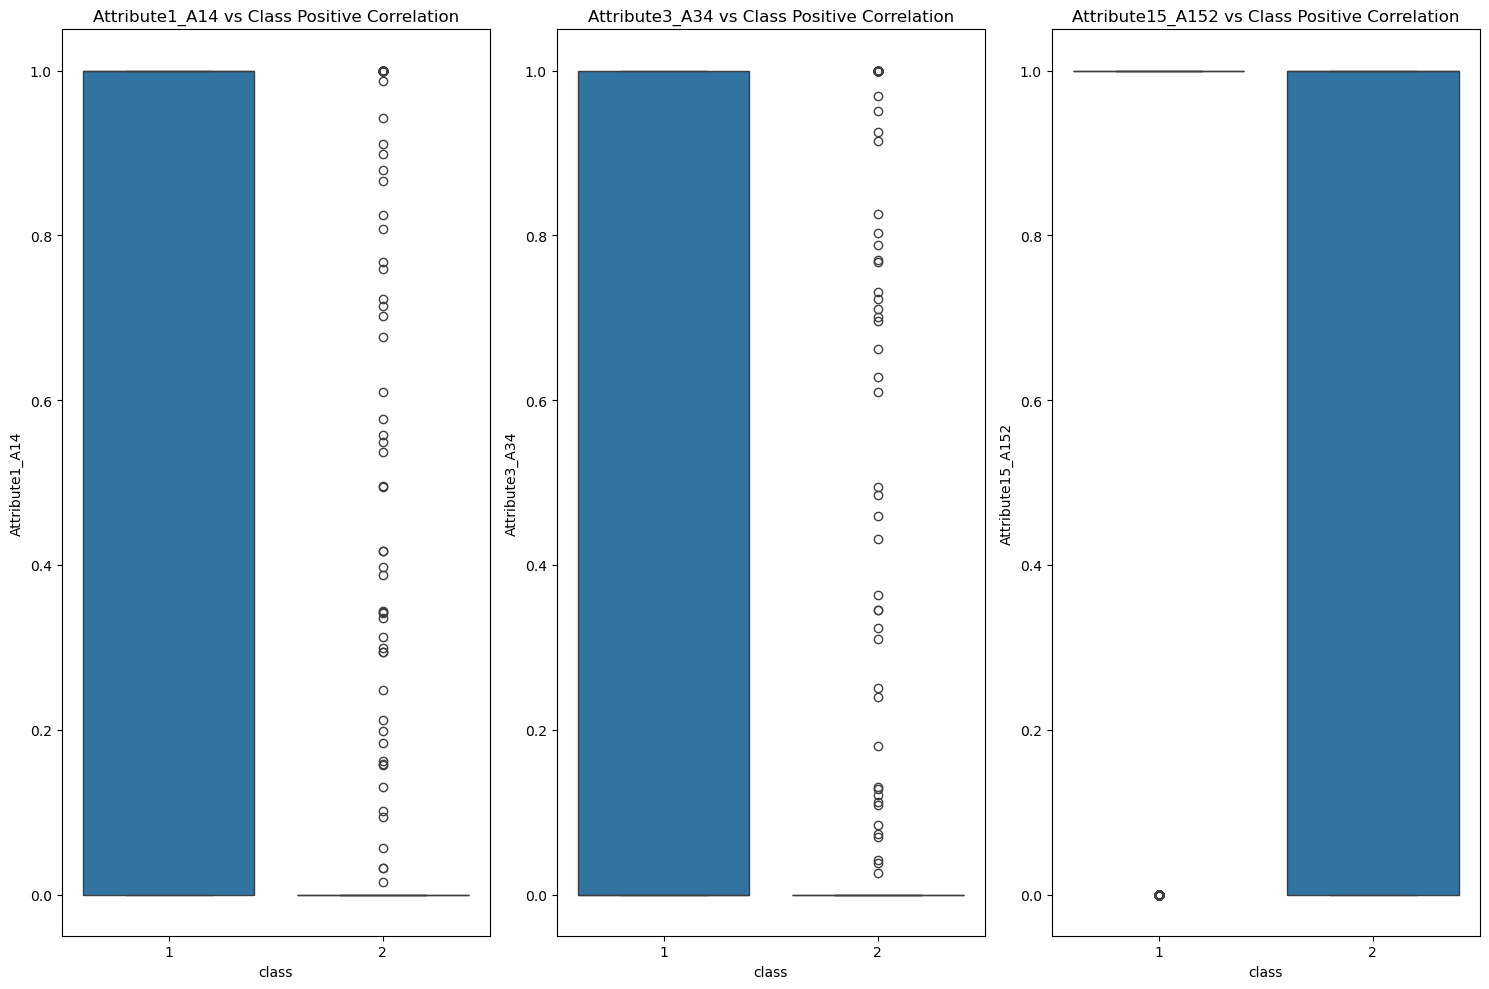

In [ ]:
#%%

# Correlation inspection

sns.boxplot(x="class", y=pos_cor_feat[0], data=df_oversampled)
plt.title(f'{pos_cor_feat[0]} vs Class Positive Correlation')
plt.tight_layout()
plt.show()

f, axes = plt.subplots(ncols=len(neg_cor_feat), figsize=(15,10))

for i, feature in enumerate(neg_cor_feat):
    sns.boxplot(x="class", y=f"{feature}", data=df_oversampled, ax=axes[i])
    axes[i].set_title(f'{feature} vs Class Positive Correlation')

plt.tight_layout()
plt.show()

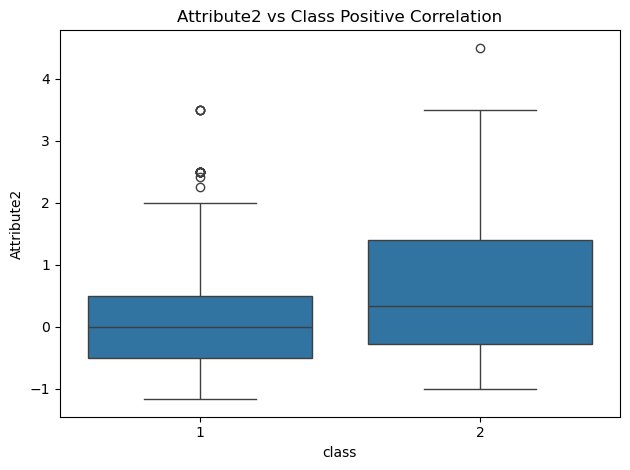

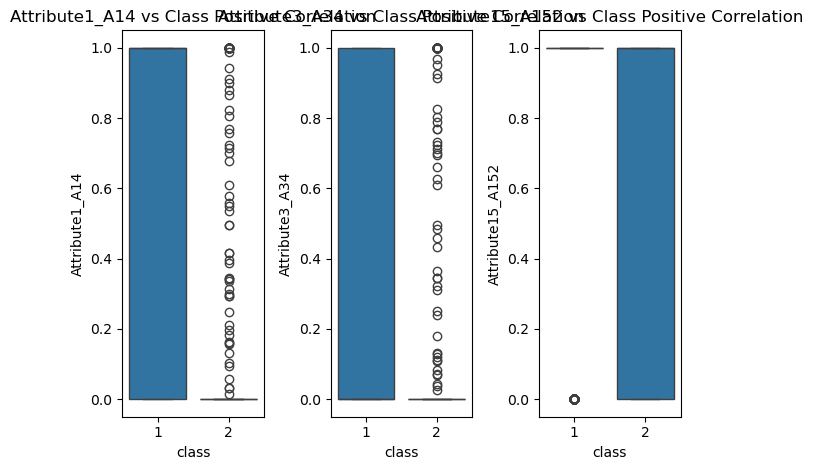

In [ ]:
#%%

# Correlation inspection

sns.boxplot(x="class", y=pos_cor_feat[0], data=df_oversampled)
plt.title(f'{pos_cor_feat[0]} vs Class Positive Correlation')
plt.tight_layout()
plt.show()

f, axes = plt.subplots(ncols=len(neg_cor_feat))

for i, feature in enumerate(neg_cor_feat):
    sns.boxplot(x="class", y=f"{feature}", data=df_oversampled, ax=axes[i])
    axes[i].set_title(f'{feature} vs Class Positive Correlation')

plt.tight_layout()
plt.show()

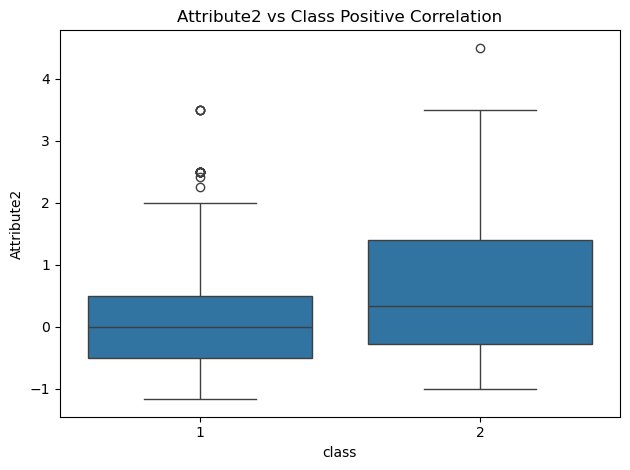

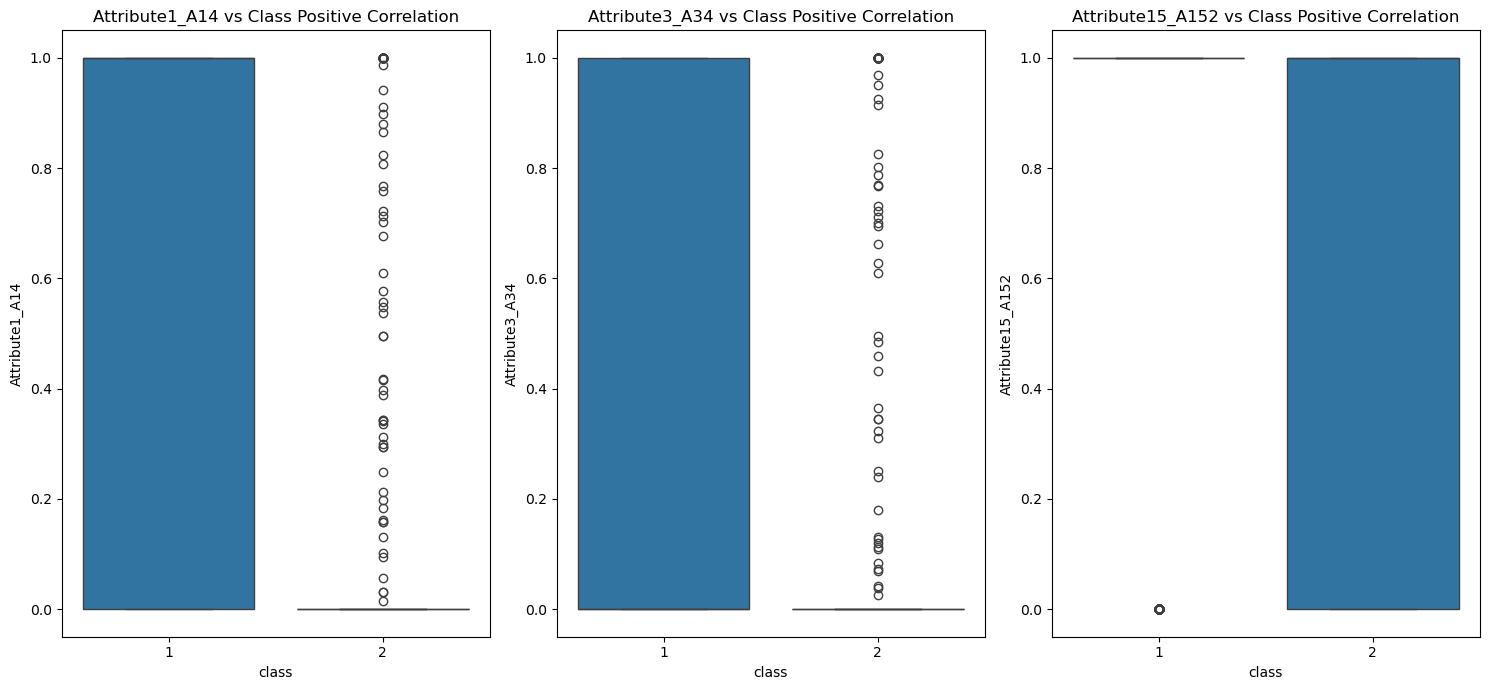

In [ ]:
#%%

# Correlation inspection

sns.boxplot(x="class", y=pos_cor_feat[0], data=df_oversampled)
plt.title(f'{pos_cor_feat[0]} vs Class Positive Correlation')
plt.tight_layout()
plt.show()

f, axes = plt.subplots(ncols=len(neg_cor_feat), figsize=(15,7))

for i, feature in enumerate(neg_cor_feat):
    sns.boxplot(x="class", y=f"{feature}", data=df_oversampled, ax=axes[i])
    axes[i].set_title(f'{feature} vs Class Positive Correlation')

plt.tight_layout()
plt.show()

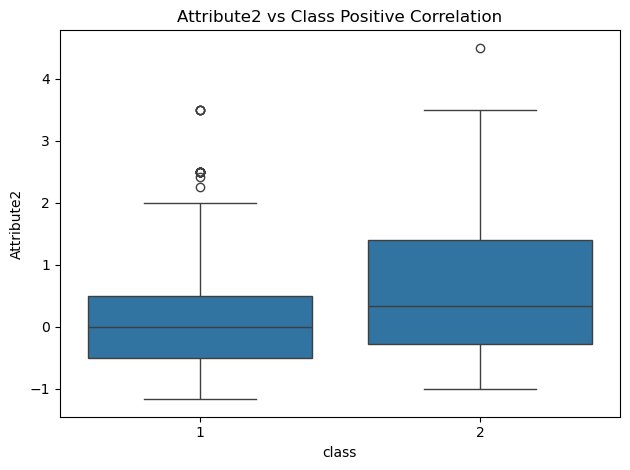

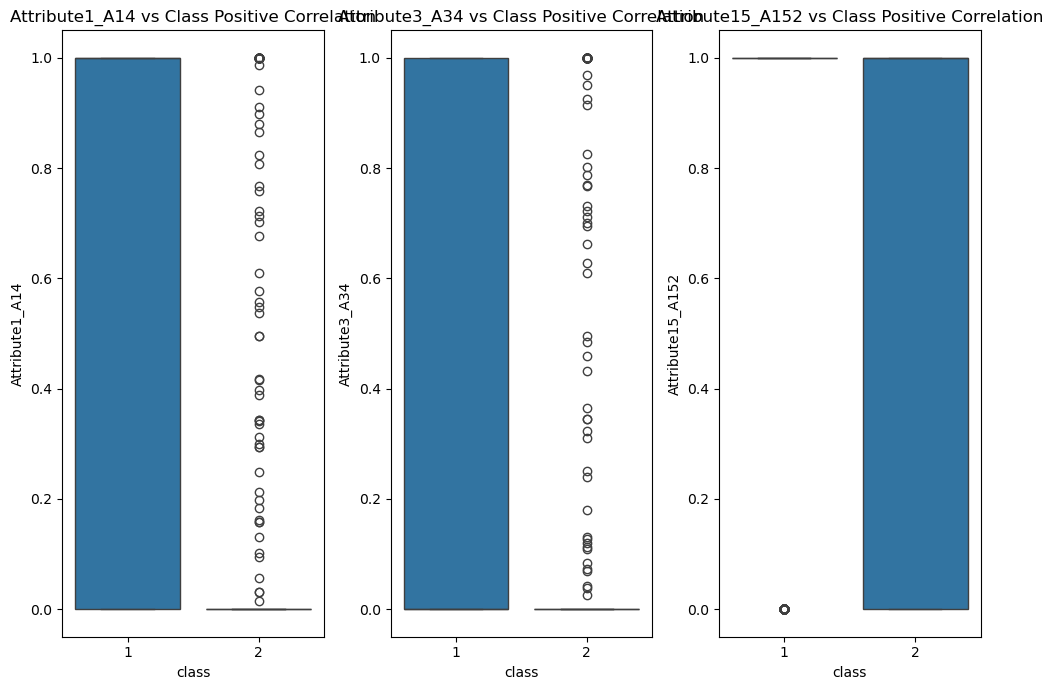

In [ ]:
#%%

# Correlation inspection

sns.boxplot(x="class", y=pos_cor_feat[0], data=df_oversampled)
plt.title(f'{pos_cor_feat[0]} vs Class Positive Correlation')
plt.tight_layout()
plt.show()

f, axes = plt.subplots(ncols=len(neg_cor_feat), figsize=(10,7))

for i, feature in enumerate(neg_cor_feat):
    sns.boxplot(x="class", y=f"{feature}", data=df_oversampled, ax=axes[i])
    axes[i].set_title(f'{feature} vs Class Positive Correlation')

plt.tight_layout()
plt.show()

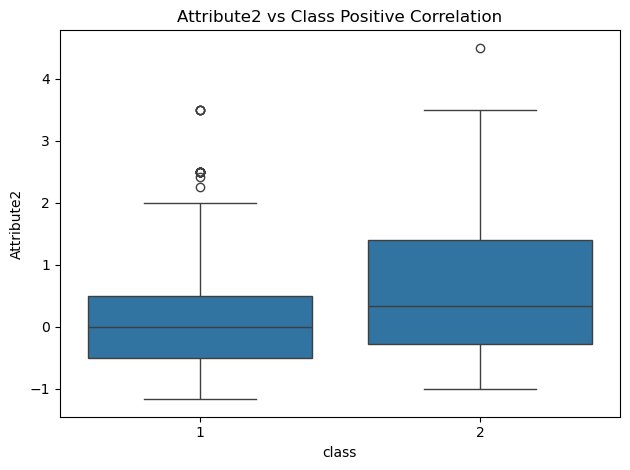

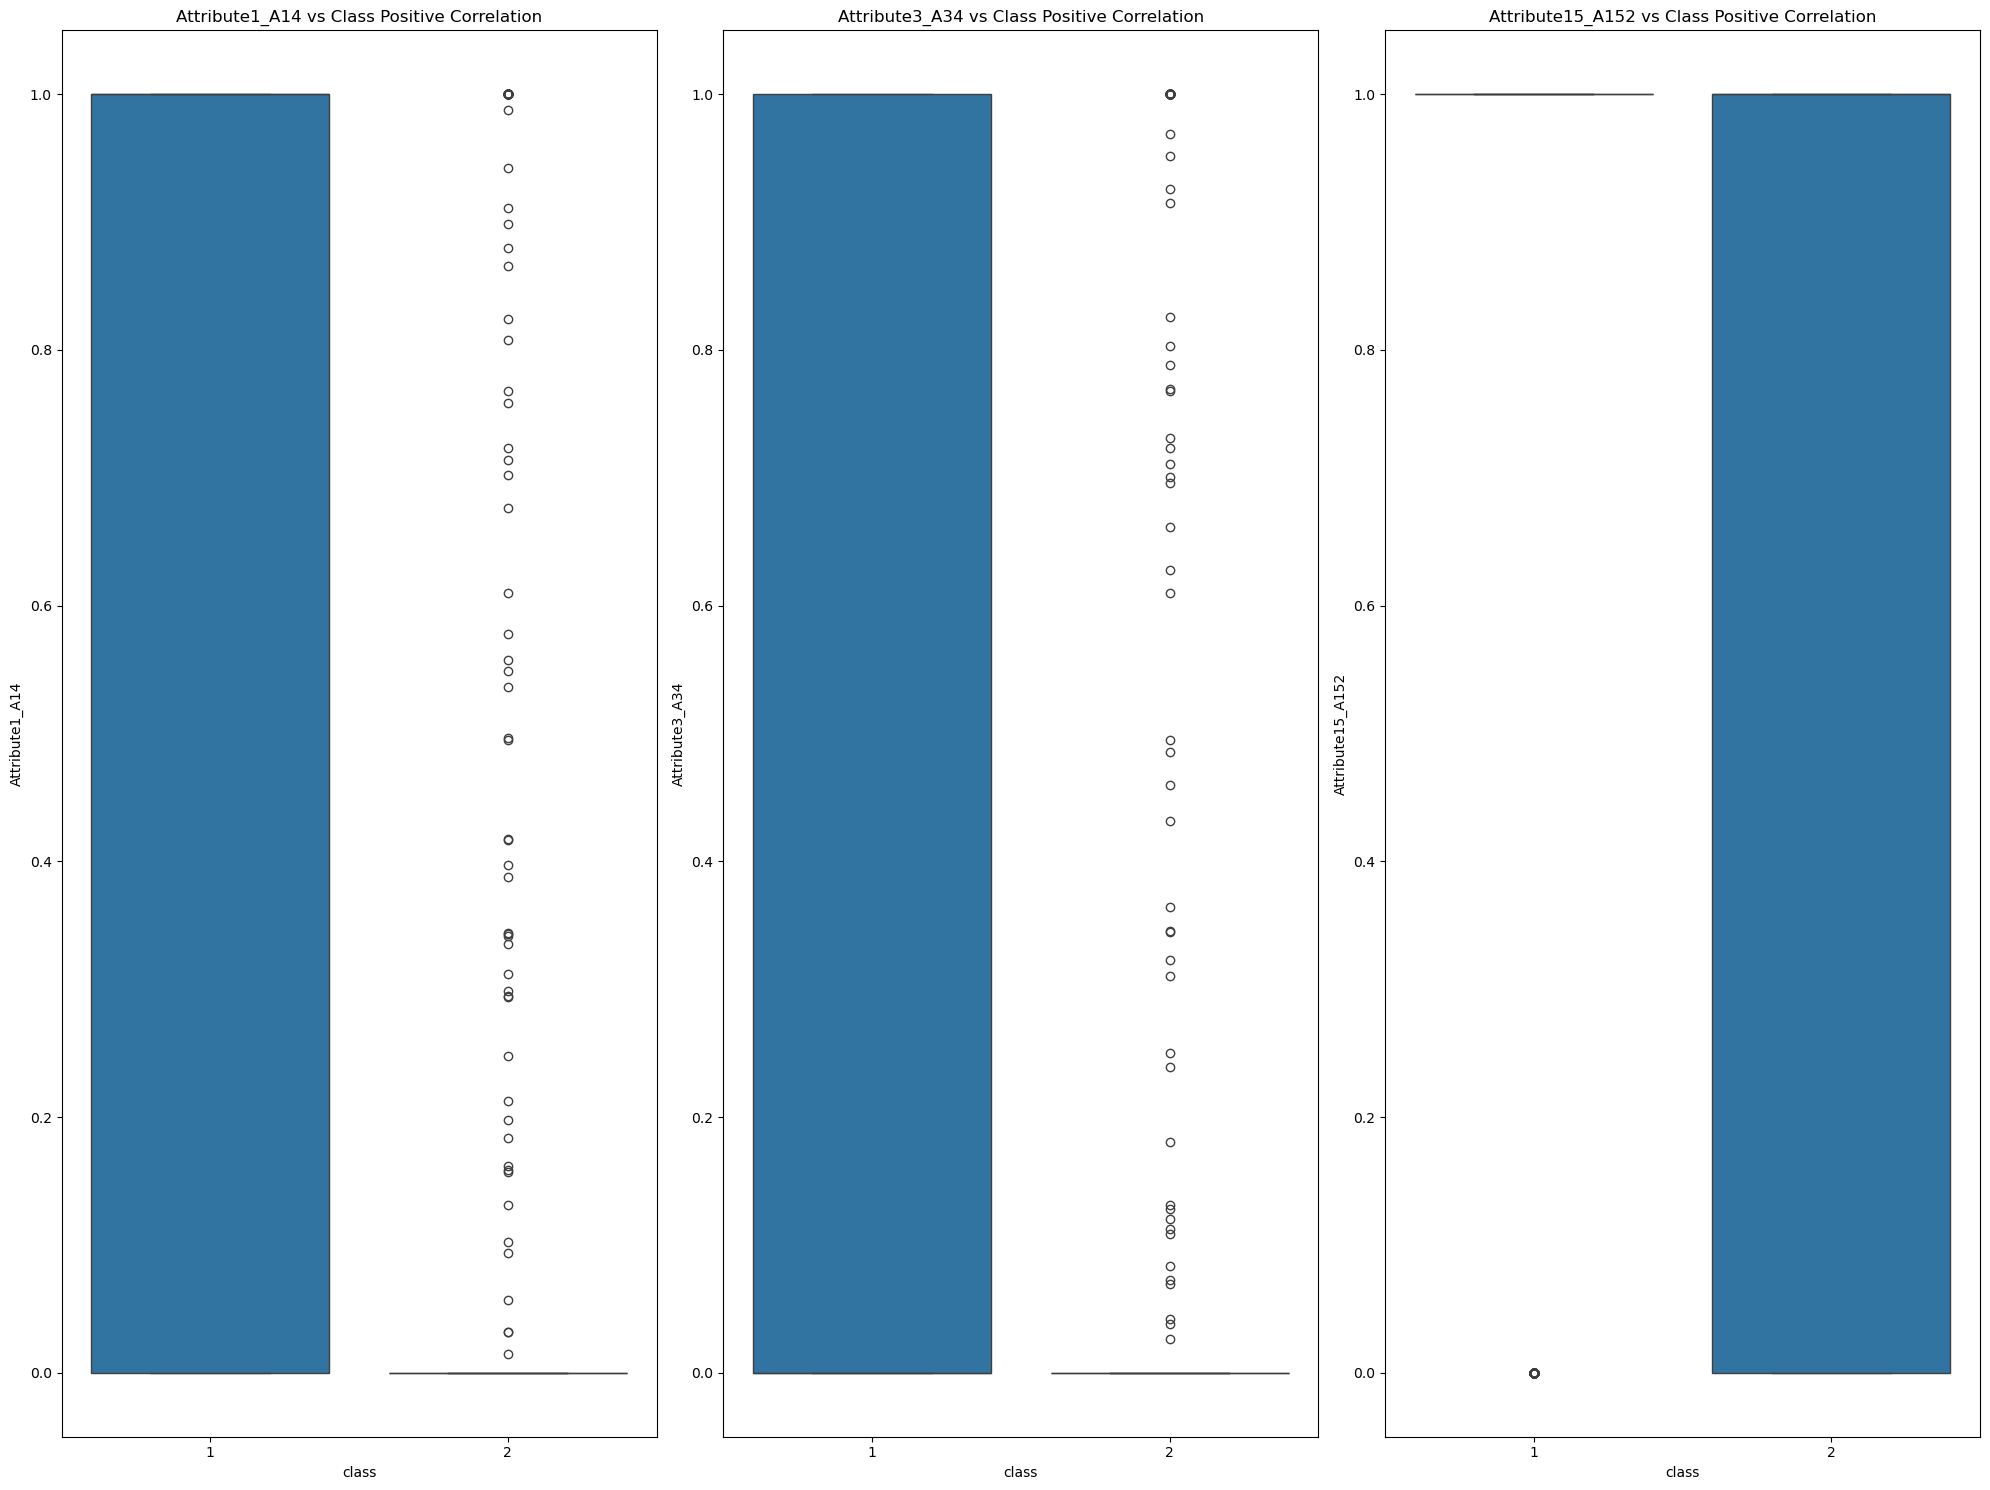

In [ ]:
#%%

# Correlation inspection

sns.boxplot(x="class", y=pos_cor_feat[0], data=df_oversampled)
plt.title(f'{pos_cor_feat[0]} vs Class Positive Correlation')
plt.tight_layout()
plt.show()

f, axes = plt.subplots(ncols=len(neg_cor_feat), figsize=(20,15))

for i, feature in enumerate(neg_cor_feat):
    sns.boxplot(x="class", y=f"{feature}", data=df_oversampled, ax=axes[i])
    axes[i].set_title(f'{feature} vs Class Positive Correlation')

plt.tight_layout()
plt.show()

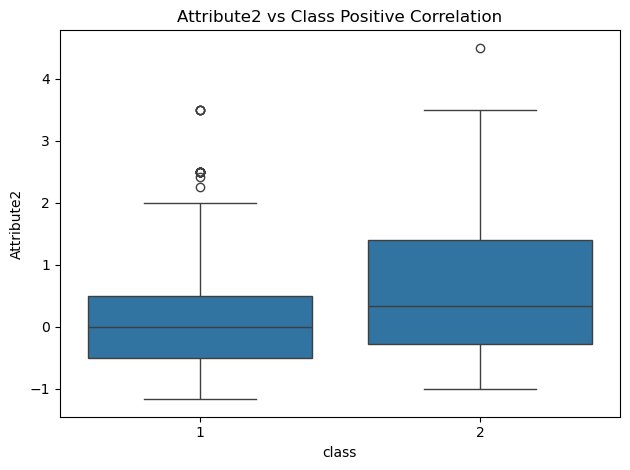

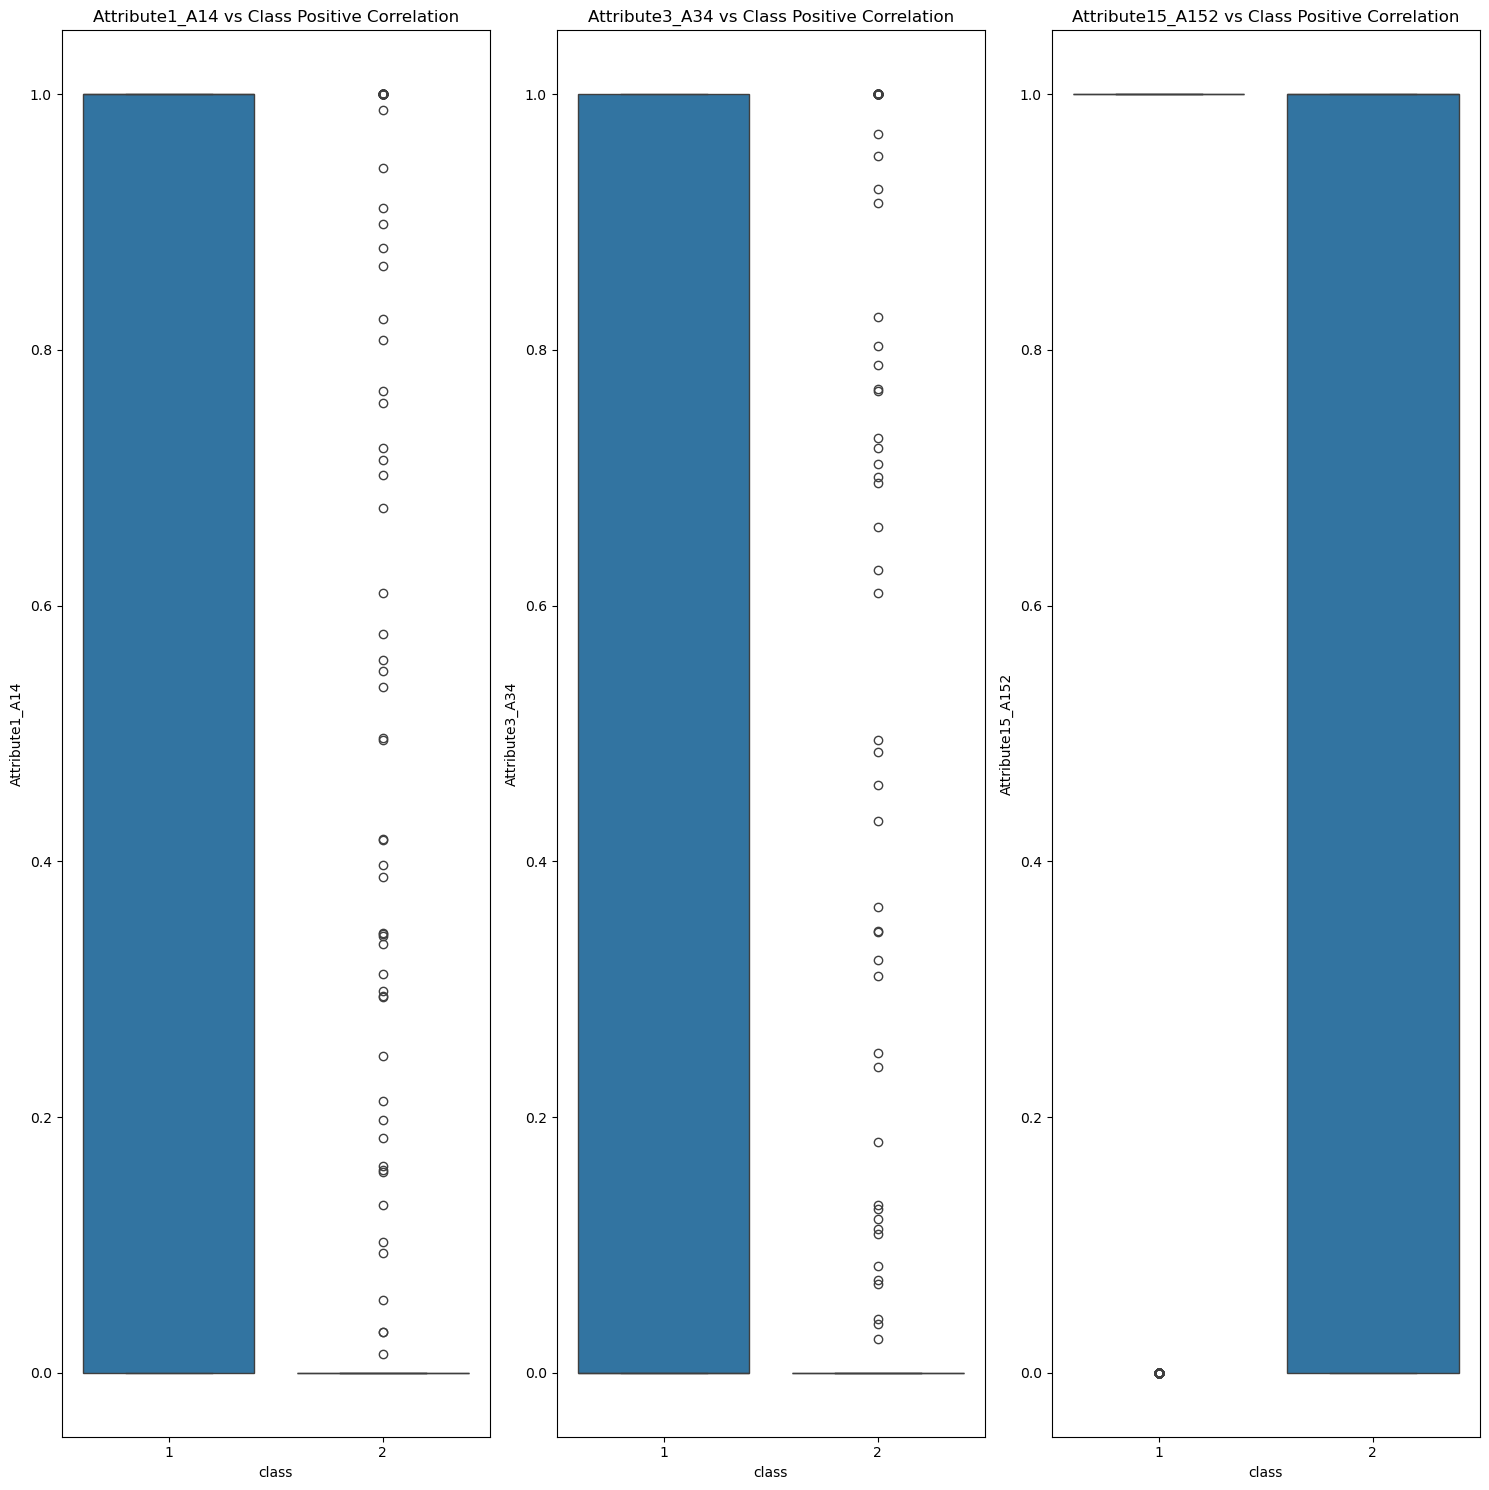

In [ ]:
#%%

# Correlation inspection

sns.boxplot(x="class", y=pos_cor_feat[0], data=df_oversampled)
plt.title(f'{pos_cor_feat[0]} vs Class Positive Correlation')
plt.tight_layout()
plt.show()

f, axes = plt.subplots(ncols=len(neg_cor_feat), figsize=(15,15))

for i, feature in enumerate(neg_cor_feat):
    sns.boxplot(x="class", y=f"{feature}", data=df_oversampled, ax=axes[i])
    axes[i].set_title(f'{feature} vs Class Positive Correlation')

plt.tight_layout()
plt.show()

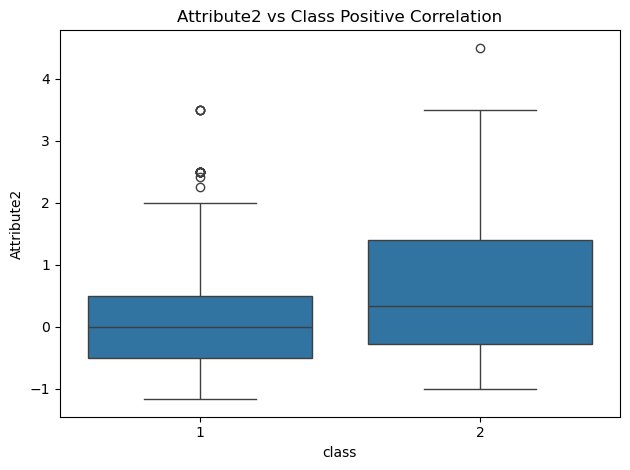

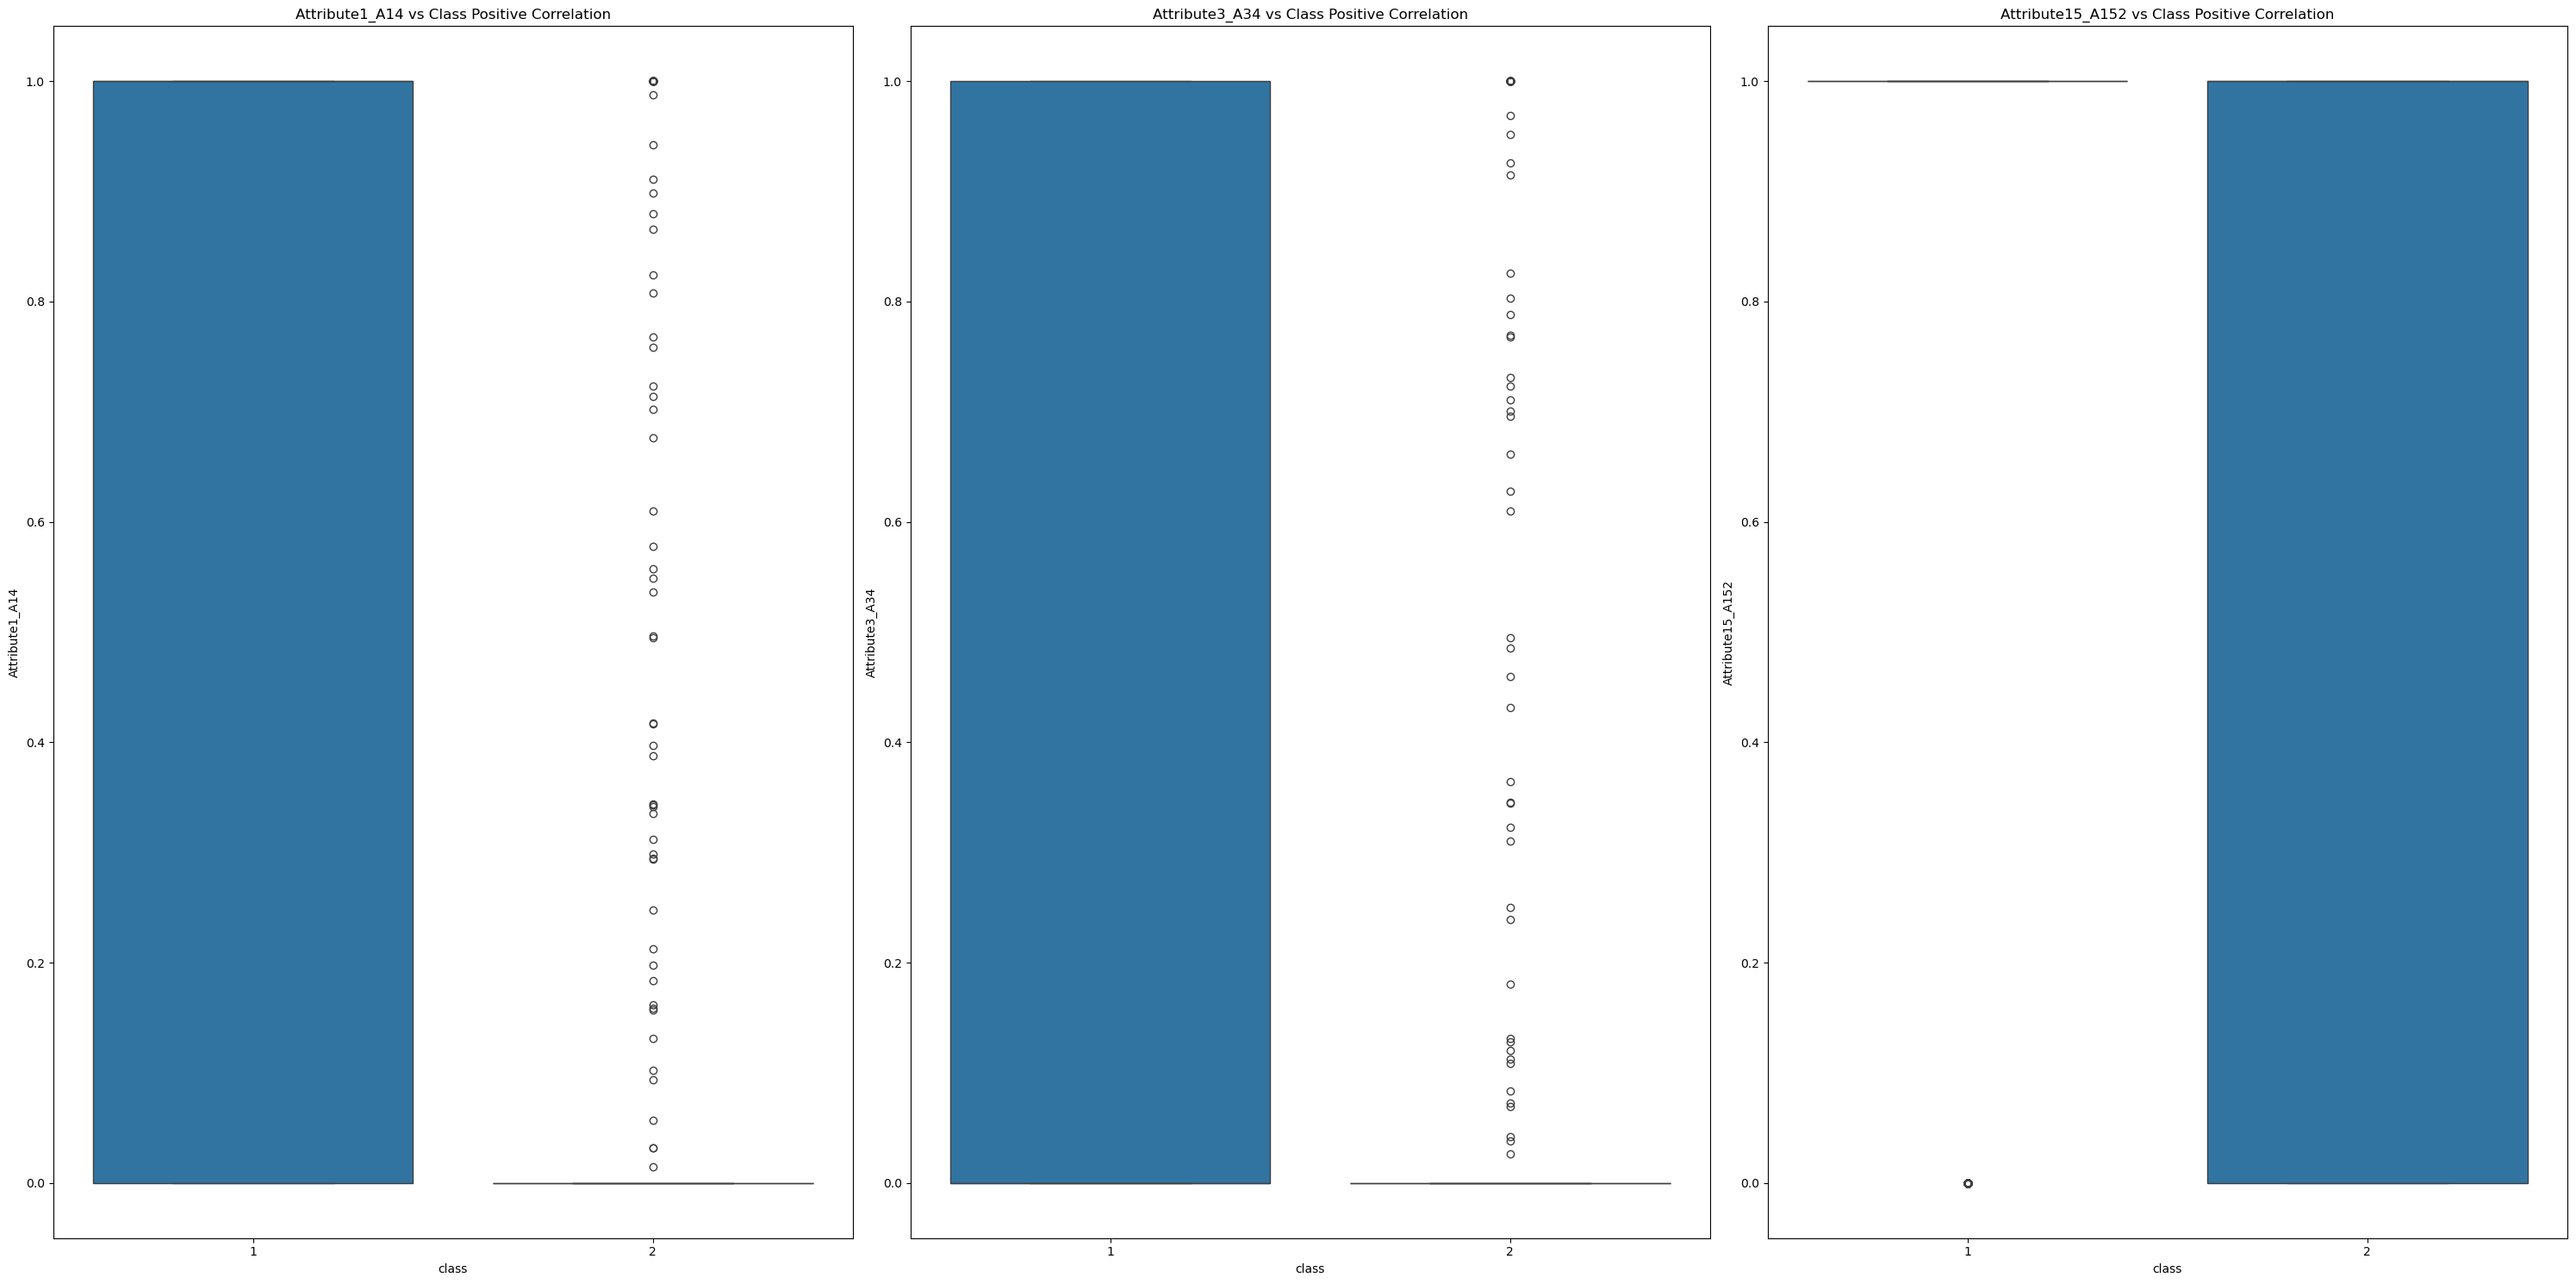

In [ ]:
#%%

# Correlation inspection

sns.boxplot(x="class", y=pos_cor_feat[0], data=df_oversampled)
plt.title(f'{pos_cor_feat[0]} vs Class Positive Correlation')
plt.tight_layout()
plt.show()

f, axes = plt.subplots(ncols=len(neg_cor_feat), figsize=(30,15))

for i, feature in enumerate(neg_cor_feat):
    sns.boxplot(x="class", y=f"{feature}", data=df_oversampled, ax=axes[i])
    axes[i].set_title(f'{feature} vs Class Positive Correlation')

plt.tight_layout()
plt.show()

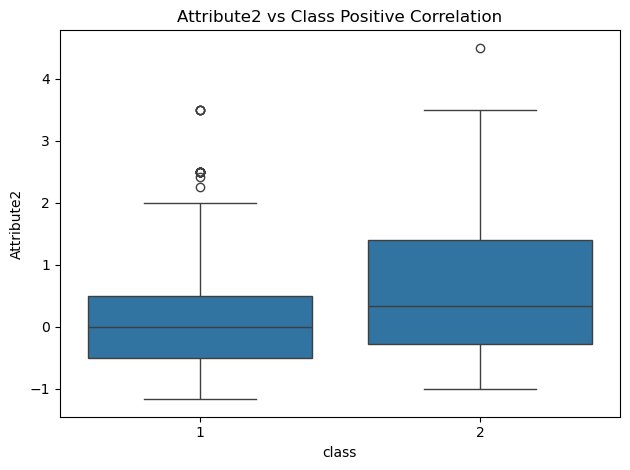

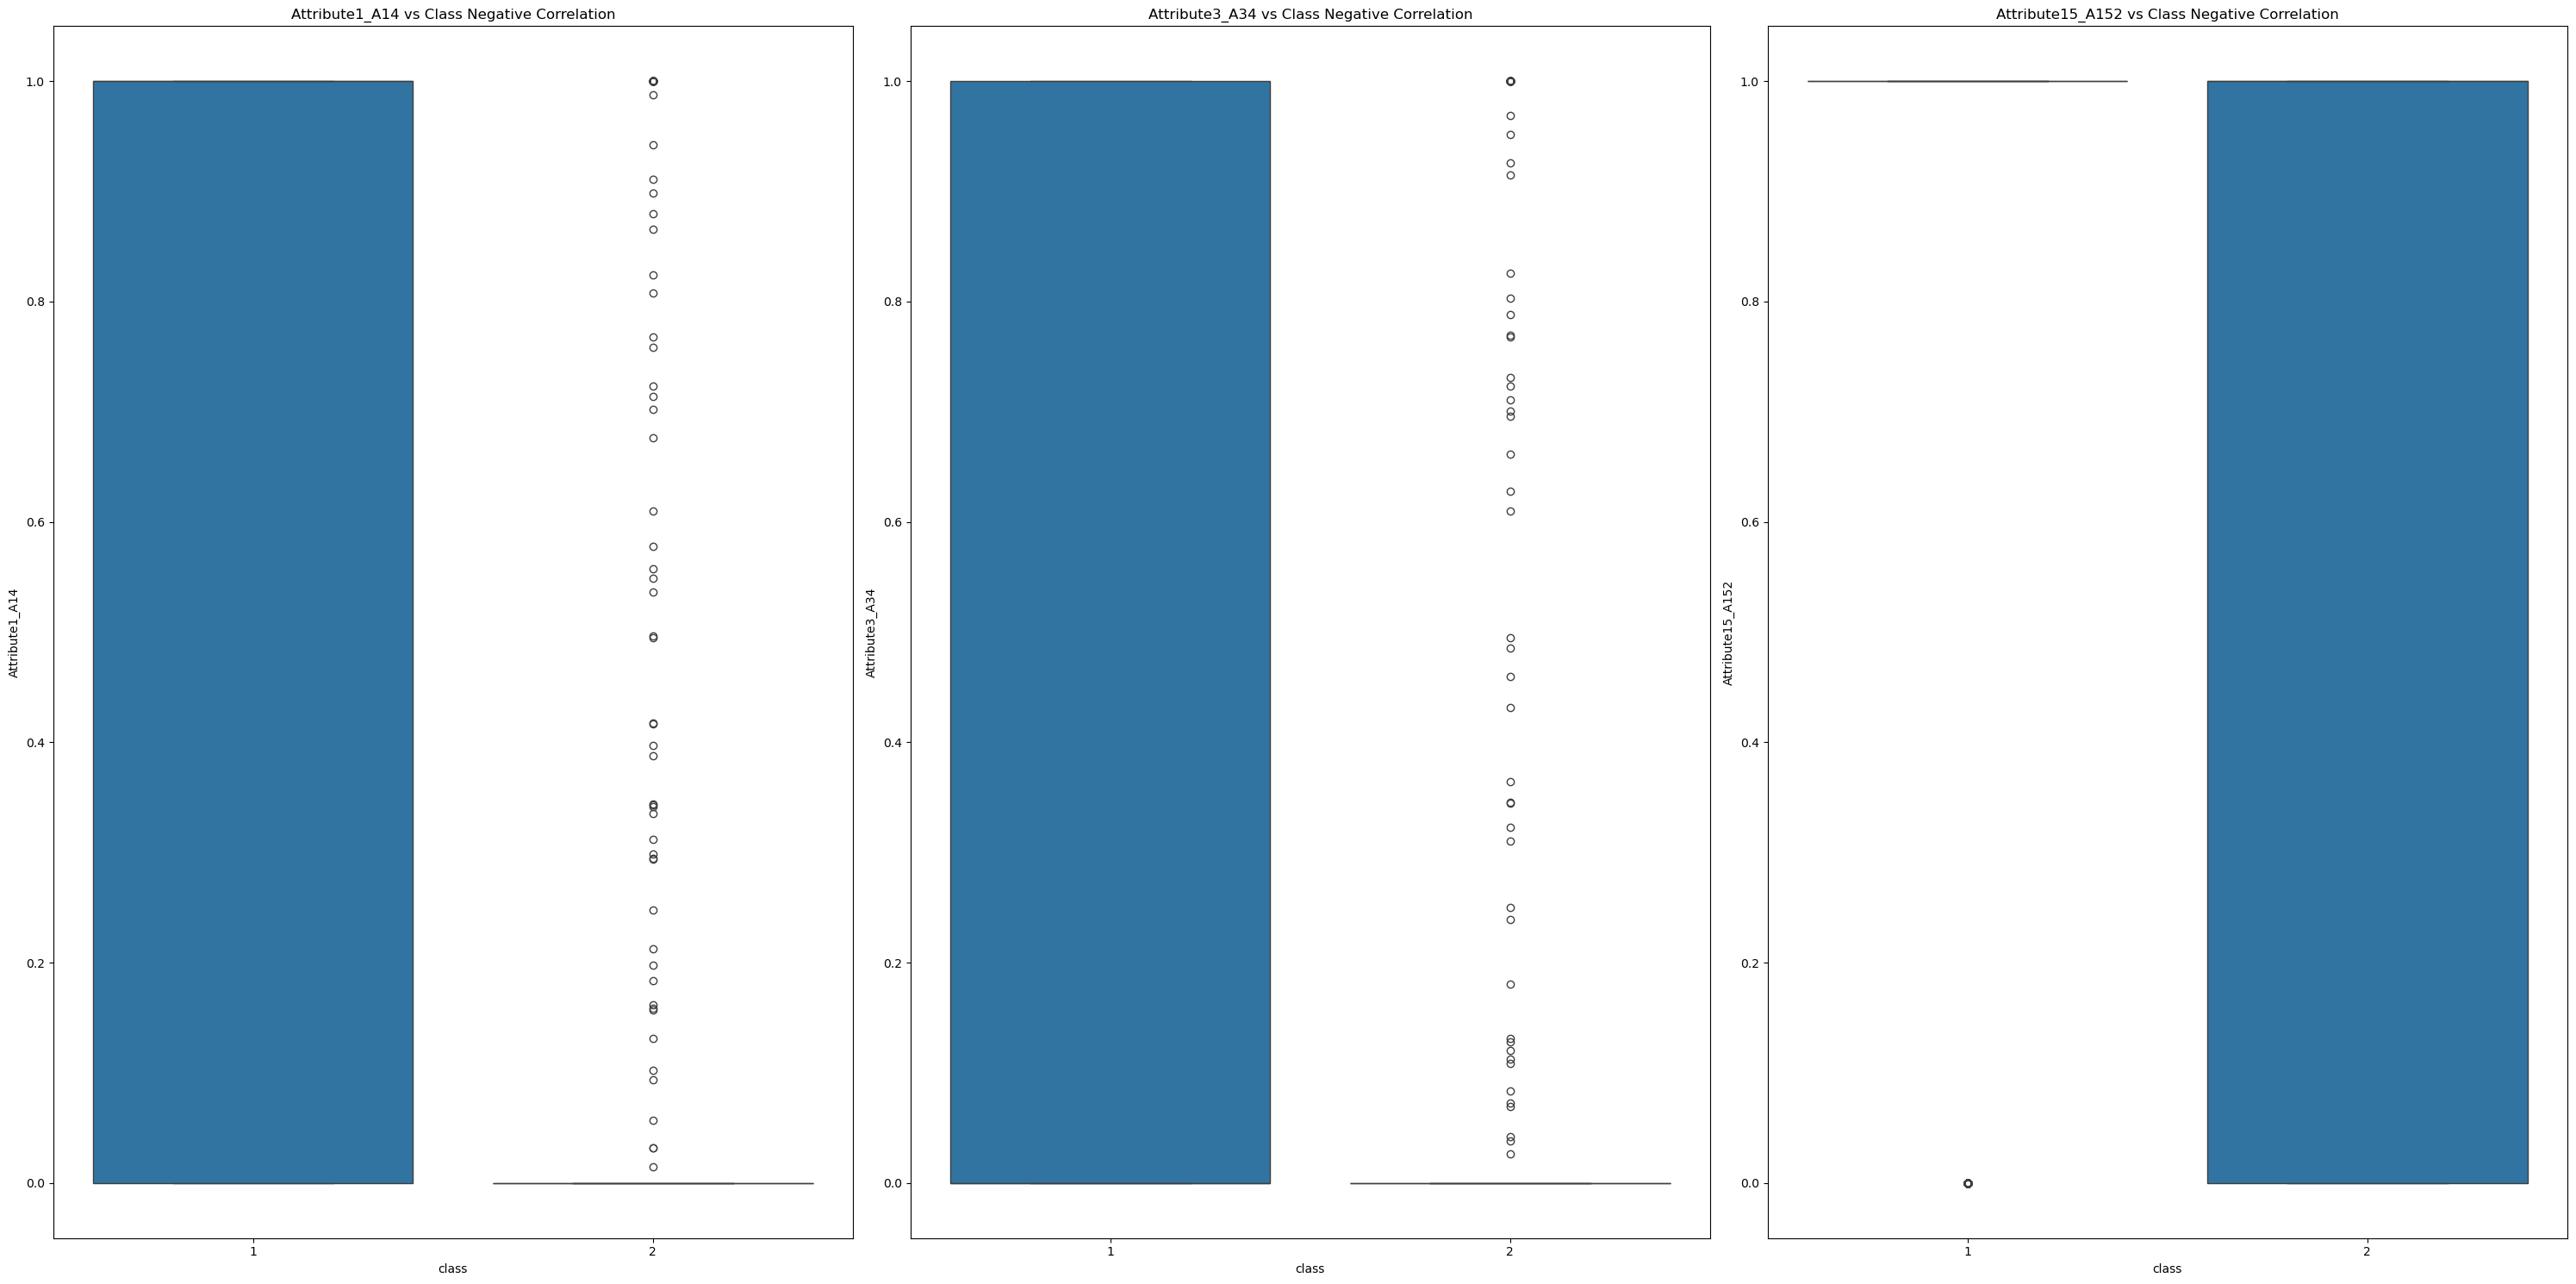

In [ ]:
#%%

# Correlation inspection

sns.boxplot(x="class", y=pos_cor_feat[0], data=df_oversampled)
plt.title(f'{pos_cor_feat[0]} vs Class Positive Correlation')
plt.tight_layout()
plt.show()

f, axes = plt.subplots(ncols=len(neg_cor_feat), figsize=(30,15))

for i, feature in enumerate(neg_cor_feat):
    sns.boxplot(x="class", y=f"{feature}", data=df_oversampled, ax=axes[i])
    axes[i].set_title(f'{feature} vs Class Negative Correlation')

plt.tight_layout()
plt.show()

In [ ]:
#%%

# Dimensionality Visualization
#t-SNE
data_embedded_TSNE = TSNE(n_components=2, random_state=37).fit_transform(X_oversampled)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

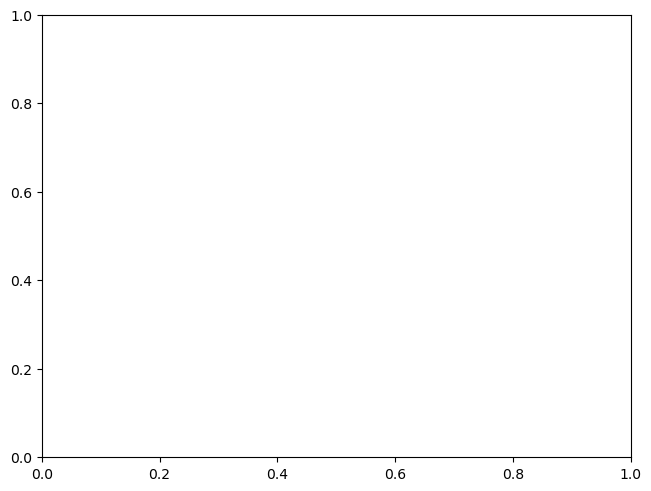

In [ ]:
#%%

fig = plt.figure(facecolor="white", constrained_layout=True)
ax = fig.add_subplot()

ax.scatter(data_embedded_TSNE[(y_oversampled == 1),0], data_embedded_TSNE[(y_oversampled == 1),1], c='yellow',  label="Non Fraud")
ax.scatter(data_embedded_TSNE[(y_oversampled == 2),0], data_embedded_TSNE[(y_oversampled == 2),1], c='blue',    label="Fraud")

ax.legend()

ax.set_title('t-SNE')
ax.grid(True)

plt.show()

In [ ]:
data_embedded_TSNE.shape

(1050, 2)

In [ ]:
y_oversampled

class
0         1
1         1
2         1
3         2
4         2
...     ...
1045      2
1046      2
1047      2
1048      2
1049      2

[1050 rows x 1 columns]

In [ ]:
y_oversampled.shape

(1050, 1)

In [ ]:
y_oversampled.ravel()

AttributeError: 'DataFrame' object has no attribute 'ravel'

In [ ]:
y_oversampled.values

array([[1],
       [1],
       [1],
       ...,
       [2],
       [2],
       [2]], dtype=int64)

In [ ]:
y_oversampled.values.ravel()

array([1, 1, 1, ..., 2, 2, 2], dtype=int64)

In [ ]:
y_oversampled.values.ravel().shape

(1050,)

In [ ]:
#%%

# Splitting data
y = y.values.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=37, stratify=y)

In [ ]:
#%%

# Oversampling
X_oversampled, y_oversampled = SMOTE(random_state=37).fit_resample(X_train, y_train)
df_oversampled = pd.concat([X_oversampled,y_oversampled], axis=1)

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

In [ ]:
#%%

# fetch dataset 
statlog_german_credit_data = fetch_ucirepo(id=144) 
  
# data (as pandas dataframes) 
X = statlog_german_credit_data.data.features 
y = statlog_german_credit_data.data.targets 
df = pd.concat([X, y], axis=1)

# metadata 
print(statlog_german_credit_data.metadata) 
  
# variable information 
print(statlog_german_credit_data.variables) 

{'uci_id': 144, 'name': 'Statlog (German Credit Data)', 'repository_url': 'https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data', 'data_url': 'https://archive.ics.uci.edu/static/public/144/data.csv', 'abstract': 'This dataset classifies people described by a set of attributes as good or bad credit risks. Comes in two formats (one all numeric). Also comes with a cost matrix', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1000, 'num_features': 20, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Other', 'Marital Status', 'Age', 'Occupation'], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5NC77', 'creators': ['Hans Hofmann'], 'intro_paper': None, 'additional_info': {'summary': 'Two datasets are provided.  the original dataset, in the form provided by

In [ ]:
#%%

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=37, stratify=y)

In [ ]:
#%%

# Oversampling
X_oversampled, y_oversampled = SMOTE(random_state=37).fit_resample(X_train, y_train)
df_oversampled = pd.concat([X_oversampled,y_oversampled], axis=1)

ValueError: could not convert string to float: 'A14'

In [ ]:
#%%

# Handling multivariate features
X.loc[:, continuous_features] = RobustScaler().fit_transform(X[continuous_features])

encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' para evitar la multicolinealidad (one feature is a linear combination of others)
encoded_categorical = encoder.fit_transform(X[categorical_features])

encoded_X = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_features))

X = X.drop(columns=categorical_features).reset_index(drop=True)
encoded_X = encoded_X.reset_index(drop=True)
X = pd.concat([X, encoded_X], axis=1)

<ipython-input-104-73614b90a364>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.          2.5        -0.5         2.          0.5         1.5
  0.5         1.5        -0.5         1.         -0.5         2.5
 -0.5         0.5        -0.25        0.5         0.5         1.
  0.5         0.5        -0.75       -1.         -0.66666667 -0.5
 -0.66666667 -1.         -1.         -0.5        -0.91666667  3.5
  0.          0.5         0.         -0.5        -0.5         2.25
  2.5         0.         -0.66666667 -0.75        1.         -0.5
  0.          1.          2.5        -0.58333333  1.5        -1.
 -0.58333333 -0.5         0.5         0.75       -0.5         0.
  1.5        -1.         -0.5         1.5         0.          1.5
 -0.75       -0.25        1.5         2.5         0.5         0.75
 -0.5        -0.5         1.5         1.5         1.5        -0.91666667
 -0.83333333  2.          1.5        -0.5       

In [ ]:
#%%

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=37, stratify=y)

In [ ]:
#%%

# Oversampling
X_oversampled, y_oversampled = SMOTE(random_state=37).fit_resample(X_train, y_train)
df_oversampled = pd.concat([X_oversampled,y_oversampled], axis=1)

In [ ]:
#%%

# Dimensionality Visualization
#t-SNE
data_embedded_TSNE = TSNE(n_components=2, random_state=37).fit_transform(X_oversampled)

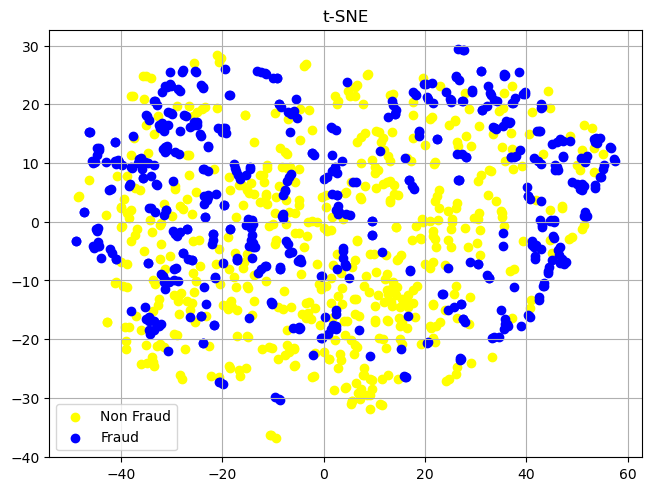

In [ ]:
#%%

fig = plt.figure(facecolor="white", constrained_layout=True)
ax = fig.add_subplot()

y_oversampled_flat = y_oversampled.values.ravel()

ax.scatter(data_embedded_TSNE[(y_oversampled_flat == 1),0], data_embedded_TSNE[(y_oversampled_flat == 1),1], c='yellow',  label="Non Fraud")
ax.scatter(data_embedded_TSNE[(y_oversampled_flat == 2),0], data_embedded_TSNE[(y_oversampled_flat == 2),1], c='blue',    label="Fraud")

ax.legend()

ax.set_title('t-SNE')
ax.grid(True)

plt.show()

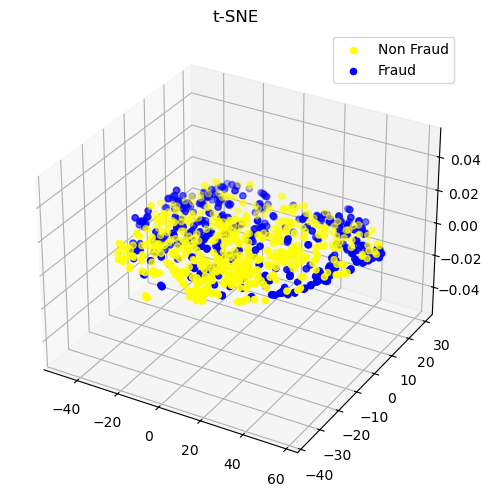

In [ ]:
#%%

fig = plt.figure(facecolor="white", constrained_layout=True)
ax = fig.add_subplot(projection='3d')

y_oversampled_flat = y_oversampled.values.ravel()

ax.scatter(data_embedded_TSNE[(y_oversampled_flat == 1),0], data_embedded_TSNE[(y_oversampled_flat == 1),1], c='yellow',  label="Non Fraud")
ax.scatter(data_embedded_TSNE[(y_oversampled_flat == 2),0], data_embedded_TSNE[(y_oversampled_flat == 2),1], c='blue',    label="Fraud")

ax.legend()

ax.set_title('t-SNE')
ax.grid(True)

plt.show()

In [ ]:
#%%

# Dimensionality Visualization
#t-SNE
data_embedded_TSNE = TSNE(n_components=3, random_state=37).fit_transform(X_oversampled)

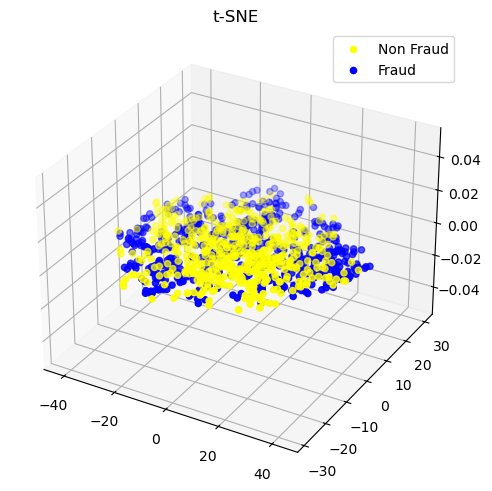

In [ ]:
#%%

fig = plt.figure(facecolor="white", constrained_layout=True)
ax = fig.add_subplot(projection='3d')

y_oversampled_flat = y_oversampled.values.ravel()

ax.scatter(data_embedded_TSNE[(y_oversampled_flat == 1),0], data_embedded_TSNE[(y_oversampled_flat == 1),1], c='yellow',  label="Non Fraud")
ax.scatter(data_embedded_TSNE[(y_oversampled_flat == 2),0], data_embedded_TSNE[(y_oversampled_flat == 2),1], c='blue',    label="Fraud")

ax.legend()

ax.set_title('t-SNE')
ax.grid(True)

plt.show()

In [ ]:
#%%

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=37, stratify=y)

In [ ]:
#%%

# Oversampling
X_oversampled, y_oversampled = SMOTE(random_state=37).fit_resample(X_train, y_train)
df_oversampled = pd.concat([X_oversampled,y_oversampled], axis=1)

In [ ]:
#%%

# Dimensionality Visualization
#t-SNE
data_embedded_TSNE = TSNE(n_components=3, random_state=37).fit_transform(X_oversampled)

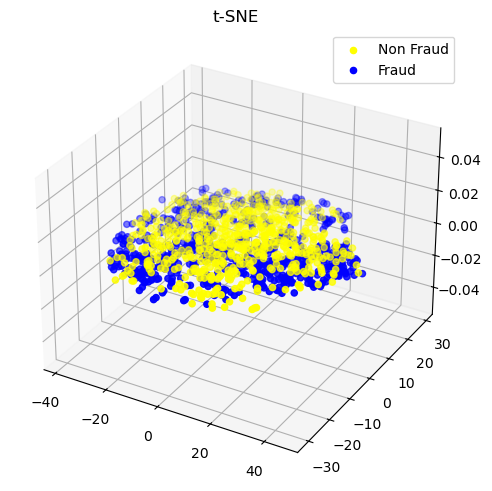

In [ ]:
#%%

fig = plt.figure(facecolor="white", constrained_layout=True)
ax = fig.add_subplot(projection='3d')

y_oversampled_flat = y_oversampled.values.ravel()

ax.scatter(data_embedded_TSNE[(y_oversampled_flat == 1),0], data_embedded_TSNE[(y_oversampled_flat == 1),1], c='yellow',  label="Non Fraud")
ax.scatter(data_embedded_TSNE[(y_oversampled_flat == 2),0], data_embedded_TSNE[(y_oversampled_flat == 2),1], c='blue',    label="Fraud")

ax.legend()

ax.set_title('t-SNE')
ax.grid(True)

plt.show()

In [ ]:
Counter(y_oversampled)

Counter({'class': 1})

In [ ]:
Counter(y_oversampled['class'])

Counter({1: 630, 2: 630})

In [ ]:
#%%

import os
os.makedirs('./credit_scoring/plots', exist_ok=True)
os.makedirs('./credit_scoring/models', exist_ok=True)

from ucimlrepo import fetch_ucirepo 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler, OneHotEncoder

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.manifold import TSNE

from imblearn.over_sampling import SMOTE

from collections import Counter

from xgboost import XGBClassifier

In [ ]:
#%%

# Classifier task
XGB_model = XGBClassifier(random_state=37)

In [ ]:
#%%

# Classifier task
XGB_model = XGBClassifier(random_state=37)

score = cross_val_score(XGB_model, X_oversampled, y_oversampled_flat,
                             cv=StratifiedKFold(n_splits=5, random_state=37, shuffle=True), scoring='accuracy')

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaqu\anaconda3\envs\data_science\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaqu\anaconda3\envs\data_science\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\joaqu\anaconda3\envs\data_science\Lib\site-packages\xgboost\sklearn.py", line 1491, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got [1 2]


In [ ]:
#%%

# Classifier task
XGB_model = XGBClassifier(random_state=37)

#1 was good, 2 was bad.
y_oversampled_flat = y_oversampled_flat.map({'1': 0, '2': 1})

score = cross_val_score(XGB_model, X_oversampled, y_oversampled_flat,
                             cv=StratifiedKFold(n_splits=5, random_state=37, shuffle=True), scoring='accuracy')

AttributeError: 'numpy.ndarray' object has no attribute 'map'

In [ ]:
y_oversampled_flat

array([1, 1, 2, ..., 2, 2, 2], dtype=int64)

In [ ]:
#%%

# Classifier task
XGB_model = XGBClassifier(random_state=37)

#1 was good, 2 was bad.
y = y.map({'1': 0, '2': 1})

score = cross_val_score(XGB_model, X_oversampled, y_oversampled_flat,
                             cv=StratifiedKFold(n_splits=5, random_state=37, shuffle=True), scoring='accuracy')

TypeError: the first argument must be callable

In [ ]:
y

class
0        1
1        2
2        1
3        1
4        2
..     ...
995      1
996      1
997      1
998      2
999      1

[1000 rows x 1 columns]

In [ ]:
#%%

# Classifier task
XGB_model = XGBClassifier(random_state=37)

#1 was good, 2 was bad.
y_oversampled = y_oversampled['class'].map({'1': 0, '2': 1})

score = cross_val_score(XGB_model, X_oversampled, y_oversampled_flat,
                             cv=StratifiedKFold(n_splits=5, random_state=37, shuffle=True), scoring='accuracy')

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaqu\anaconda3\envs\data_science\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaqu\anaconda3\envs\data_science\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\joaqu\anaconda3\envs\data_science\Lib\site-packages\xgboost\sklearn.py", line 1491, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got [1 2]


In [ ]:
y_oversampled['class'].map({'1': 0, '2': 1})

KeyError: 'class'

In [ ]:
y_oversampled

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
1255   NaN
1256   NaN
1257   NaN
1258   NaN
1259   NaN
Name: class, Length: 1260, dtype: float64

In [ ]:
#%%

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=37, stratify=y)

In [ ]:
#%%

# Oversampling
X_oversampled, y_oversampled = SMOTE(random_state=37).fit_resample(X_train, y_train)
df_oversampled = pd.concat([X_oversampled,y_oversampled], axis=1)

In [ ]:
y_oversampled

class
0         1
1         1
2         2
3         1
4         2
...     ...
1255      2
1256      2
1257      2
1258      2
1259      2

[1260 rows x 1 columns]

In [ ]:
y_oversampled['class']

0       1
1       1
2       2
3       1
4       2
       ..
1255    2
1256    2
1257    2
1258    2
1259    2
Name: class, Length: 1260, dtype: int64

In [ ]:
y_oversampled['class'].shape

(1260,)

In [ ]:
#%%

# Classifier task
XGB_model = XGBClassifier(random_state=37)

#1 was good, 2 was bad.
y_oversampled = y_oversampled['class'].map({1: 0, 2: 1})

In [ ]:
y_oversampled

0       0
1       0
2       1
3       0
4       1
       ..
1255    1
1256    1
1257    1
1258    1
1259    1
Name: class, Length: 1260, dtype: int64

In [ ]:
#%%

# Classifier task
XGB_model = XGBClassifier(random_state=37)

#1 was good, 2 was bad.
y_oversampled = y_oversampled['class'].map({1: 0, 2: 1})

score = cross_val_score(XGB_model, X_oversampled, y_oversampled,
                             cv=StratifiedKFold(n_splits=5, random_state=37, shuffle=True), scoring='accuracy')

KeyError: 'class'

In [ ]:
#%%

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=37, stratify=y)

In [ ]:
#%%

# Oversampling
X_oversampled, y_oversampled = SMOTE(random_state=37).fit_resample(X_train, y_train)
df_oversampled = pd.concat([X_oversampled,y_oversampled], axis=1)

In [ ]:
#%%

# Classifier task
XGB_model = XGBClassifier(random_state=37)

#1 was good, 2 was bad.
y_oversampled_target = y_oversampled['class'].map({1: 0, 2: 1})

score = cross_val_score(XGB_model, X_oversampled, y_oversampled_target,
                             cv=StratifiedKFold(n_splits=5, random_state=37, shuffle=True), scoring='accuracy')

In [ ]:
score

array([0.81746032, 0.84920635, 0.8452381 , 0.83730159, 0.81349206])

In [ ]:
#%%

import os
os.makedirs('./credit_scoring/plots', exist_ok=True)
os.makedirs('./credit_scoring/models', exist_ok=True)

from ucimlrepo import fetch_ucirepo 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.manifold import TSNE

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

import time
from collections import Counter

In [ ]:
#%% 

# GridSearch - RandomSearchCV
y_test_target = y_test['class'].map({1: 0, 2: 1})

param_dist = {
    'n_estimators': np.arange(50, 300, 50),
    'max_depth': np.arange(3, 10),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': np.linspace(0, 0.5, 5),
    'reg_alpha': np.logspace(-3, 0, 5),
    'reg_lambda': np.logspace(-1, 1, 5)
}

random_search = RandomizedSearchCV(estimator=XGB_model, param_distributions=param_dist, 
                                   n_iter=50, scoring='accuracy', cv=5, verbose=1, random_state=37)

start = time.time()
random_search.fit(X_oversampled, y_oversampled_target,  eval_set=[(X_test, y_test_target)], verbose=False)
print("CPU RandomizedSearchCV Time: %s seconds" % (str(time.time() - start)))

print(f"{random_search.best_params_=}")
print(f"{random_search.best_score_}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
CPU RandomizedSearchCV Time: 56.30784869194031 seconds
random_search.best_params_={'subsample': 0.6, 'reg_lambda': 0.31622776601683794, 'reg_alpha': 0.1778279410038923, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.07444444444444444, 'gamma': 0.0, 'colsample_bytree': 0.8}
0.8261904761904761


In [ ]:
#%% 

# GridSearch - RandomSearchCV
y_test_target = y_test['class'].map({1: 0, 2: 1})

param_dist = {
    'n_estimators': np.arange(50, 300, 50),  
    'max_depth': np.arange(3, 8),
    'learning_rate': np.linspace(0.01, 0.3, 10), 
    'subsample': np.linspace(0.6, 0.9, 4).tolist() + [1.0], 
    'colsample_bytree': np.linspace(0.6, 0.9, 4).tolist() + [1.0],
    'gamma': np.linspace(0, 0.5, 5),    
    'min_child_weight': np.arange(1, 6),
    'reg_alpha': np.logspace(-3, 0, 5), 
    'reg_lambda': np.logspace(-1, 1, 5) 
}

random_search = RandomizedSearchCV(estimator=XGB_model, param_distributions=param_dist, 
                                   n_iter=50, scoring='accuracy', cv=5, verbose=1, random_state=37)

start = time.time()
random_search.fit(X_oversampled, y_oversampled_target,  eval_set=[(X_test, y_test_target)], verbose=False)
print("CPU RandomizedSearchCV Time: %s seconds" % (str(time.time() - start)))

print(f"{random_search.best_params_=}")
print(f"{random_search.best_score_}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
CPU RandomizedSearchCV Time: 54.45628356933594 seconds
random_search.best_params_={'subsample': 0.8, 'reg_lambda': 1.0, 'reg_alpha': 0.03162277660168379, 'n_estimators': 150, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.07444444444444444, 'gamma': 0.0, 'colsample_bytree': 1.0}
0.8261904761904761


In [ ]:
#%%

# Train with best results
XGB_best_params = XGBClassifier(**random_search.best_params_)
XGB_best_params.fit(X_oversampled, y_oversampled_target)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07444444444444444,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
#%%

# Plot results

In [ ]:
#%%

import os
os.makedirs('./credit_scoring/plots', exist_ok=True)
os.makedirs('./credit_scoring/models', exist_ok=True)

from ucimlrepo import fetch_ucirepo 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.manifold import TSNE

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score


import time
from collections import Counter

In [ ]:
#%%

y_train_predict = XGB_best_params.predict(X_oversampled)
y_test_predict  = XGB_best_params.predict(X_test)

acc_train = accuracy_score(y_oversampled_target, y_train_predict)
pre_train = precision_score(y_oversampled_target, y_train_predict)

In [ ]:
acc_train

0.9928571428571429

In [ ]:
pre_train

0.9952153110047847

In [ ]:
#%%

y_train_predict = XGB_best_params.predict(X_oversampled)
y_test_predict  = XGB_best_params.predict(X_test)

acc_train = accuracy_score(y_oversampled_target, y_train_predict)
pre_train = precision_score(y_oversampled_target, y_train_predict)

acc_test = accuracy_score(y_test_target, y_test_predict) 
pre_test = precision_score(y_test_target,y_test_predict)

In [ ]:
acc_test

0.75

In [ ]:
pre_test

0.5806451612903226

In [ ]:
#%%

score = cross_val_score(XGB_best_params, X_oversampled, y_oversampled_target,
                             cv=StratifiedKFold(n_splits=5, random_state=37, shuffle=True), scoring='accuracy')
print(score)

[0.80555556 0.84920635 0.81746032 0.8452381  0.83333333]


In [ ]:
[0.81746032, 0.84920635, 0.8452381 , 0.83730159, 0.81349206].mean()


AttributeError: 'list' object has no attribute 'mean'

In [ ]:
ar = np.array([0.81746032, 0.84920635, 0.8452381 , 0.83730159, 0.81349206])


In [ ]:
ar.mean()

0.832539684

In [ ]:
score.mean()

0.8301587301587302

In [ ]:
#%%

import os
os.makedirs('./credit_scoring/plots', exist_ok=True)
os.makedirs('./credit_scoring/models', exist_ok=True)

from ucimlrepo import fetch_ucirepo 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.manifold import TSNE

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score


import time
from collections import Counter

In [ ]:
#%% 

# GridSearchCV - RandomSearchCV
y_test_target = y_test['class'].map({1: 0, 2: 1})

param_dist = {
    'n_estimators': np.arange(50, 300, 50),  
    'max_depth': np.arange(3, 8),
    'learning_rate': np.linspace(0.01, 0.3, 10), 
    'subsample': np.linspace(0.6, 0.9, 4).tolist() + [1.0], 
    'colsample_bytree': np.linspace(0.6, 0.9, 4).tolist() + [1.0],
    'gamma': np.linspace(0, 0.5, 5),    
    'min_child_weight': np.arange(1, 6),
    'reg_alpha': np.logspace(-3, 0, 5), 
    'reg_lambda': np.logspace(-1, 1, 5) 
}

random_search = GridSearchCV(estimator=XGB_model, param_distributions=param_dist, 
                                   n_iter=50, scoring='accuracy', cv=5, verbose=1, random_state=37)

start = time.time()
random_search.fit(X_oversampled, y_oversampled_target,  eval_set=[(X_test, y_test_target)], verbose=False)
print("CPU RandomizedSearchCV Time: %s seconds" % (str(time.time() - start)))

print(f"{random_search.best_params_=}")
print(f"{random_search.best_score_}")

TypeError: GridSearchCV.__init__() got an unexpected keyword argument 'param_distributions'

In [ ]:
#%% 

# GridSearchCV
y_test_target = y_test['class'].map({1: 0, 2: 1})

param_grid = {
    'n_estimators': np.arange(50, 300, 50),                       
    'max_depth': np.arange(3, 8),                                 
    'learning_rate': np.linspace(0.01, 0.3, 10),                  
    'subsample': np.linspace(0.6, 0.9, 4).tolist() + [1.0],       
    'colsample_bytree': np.linspace(0.6, 0.9, 4).tolist() + [1.0],
    'gamma': np.linspace(0, 0.5, 5),                              
    'min_child_weight': np.arange(1, 6),                          
    'reg_alpha': np.logspace(-3, 0, 5),                           
    'reg_lambda': np.logspace(-1, 1, 5)                           
}

XGB_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# GridSearchCV
grid_search = GridSearchCV(estimator=XGB_model, param_grid=param_grid, 
                           scoring='accuracy', cv=5, verbose=1)

start = time.time()
grid_search.fit(X_oversampled, y_oversampled_target, eval_set=[(X_test, y_test_target)], verbose=False)
print("CPU GridSearchCV Time: %s seconds" % (str(time.time() - start)))

# Print the best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Fitting 5 folds for each of 3906250 candidates, totalling 19531250 fits


c:\Users\joaqu\anaconda3\envs\data_science\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:00:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\joaqu\anaconda3\envs\data_science\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:00:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\joaqu\anaconda3\envs\data_science\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:00:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, Us

KeyboardInterrupt: 

In [ ]:
#%% 

# GridSearchCV
y_test_target = y_test['class'].map({1: 0, 2: 1})

param_grid = {
    'n_estimators': [100, 150, 200],      
    'max_depth': [4, 5, 6],               
    'learning_rate': [0.1, 0.2],    
    'subsample': [0.75, 0.8, 0.85],       
    'colsample_bytree': [0.7, 0.75, 0.8], 
    'gamma': [0.15, 0.2, 0.25],           
    'min_child_weight': [2, 3, 4],        
    
}

XGB_model = XGBClassifier(random_state=37)

# GridSearchCV
grid_search = GridSearchCV(estimator=XGB_model, param_grid=param_grid, 
                           scoring='accuracy', cv=5, verbose=1)

start = time.time()
grid_search.fit(X_oversampled, y_oversampled_target, eval_set=[(X_test, y_test_target)], verbose=False)
print("CPU GridSearchCV Time: %s seconds" % (str(time.time() - start)))

# Print the best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Fitting 5 folds for each of 1458 candidates, totalling 7290 fits
CPU GridSearchCV Time: 1571.435265302658 seconds
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0.25, 'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.8}
Best Score: 0.8269841269841269
